In [726]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [727]:
# card 데이터 로드
card = pd.read_csv("CARD_SPENDING_RESIDENT.txt", sep="\t")

card_dong = pd.read_excel("card_instruct.xlsx", sheet_name=1, header=1).drop('Unnamed: 0', axis=1)

card = card.merge(card_dong, how='left', left_on = ['GU_CD', 'DONG_CD'], right_on = ['구코드', '행정동코드'])

In [728]:
# sk 유동인구 파일 로드
os.chdir('./sk')
files_sk = os.listdir()

sk = pd.DataFrame()

for file in files_sk[:8]:
    temp = pd.read_csv(file, sep="|")
    
    sk = sk.append(temp)

In [729]:
# cj 물류 파일 로드
os.chdir("../cj")

cj = pd.read_excel('cj_data.xlsx')

In [730]:
# cj 데이터의 시/군/구 정보 추출
dong_info  = cj[['CTPV_NM', 'CTGG_NM', 'HDNG_NM']].drop_duplicates()

년도/월/일 주차별 정보로 나누기 위해서 date_table과 합성

In [731]:
os.chdir('C:\\Users\\mo223\\Desktop\\big contest\\big_con_data')
date_table = pd.read_csv("date_table.csv")

In [732]:
date_table

,STD_DD,year,month,day,week_num,day_of_week,day_of_week_kr
0,20190201,2019,2,1,4,4,금
1,20190202,2019,2,2,4,5,토
2,20190203,2019,2,3,5,6,일
3,20190204,2019,2,4,5,0,월
4,20190205,2019,2,5,5,1,화
...,...,...,...,...,...,...,...
236,20200527,2020,5,27,21,2,수
237,20200528,2020,5,28,21,3,목
238,20200529,2020,5,29,21,4,금
239,20200530,2020,5,30,21,5,토


In [733]:
# gs 유통지수 로드
gs = pd.read_excel('gs_retail.xlsx', sheet_name = 5)

# gs 데이터 & date_table 합성
gs = gs.merge(date_table, how = 'left' ,left_on = 'OPER_DT', right_on = 'STD_DD')

gs.drop(['OPER_DT', 'STD_DD'], axis=1, inplace=True)

In [734]:
# card 데이터 & date_table & dong_info 테이블 합성
card = card.merge(date_table, how='left', on='STD_DD')
card = card.merge(dong_info, how='left', left_on = '행정동명', right_on = 'HDNG_NM')
card.drop(['STD_DD','구명', '행정동명'], axis=1, inplace=True)

# sk 데이터 & date_table & dong_info 테이블 합성
sk = sk.merge(date_table, how='left', left_on = 'STD_YMD', right_on = 'STD_DD')
sk = sk.merge(dong_info, how='left', left_on = 'HDONG_NM', right_on = 'HDNG_NM')
sk.drop(['STD_YM', 'STD_YMD', 'HDONG_NM'], axis=1, inplace = True)

In [735]:
# cj 데이터 일자 양식맞추기
cj['DL_YMD'] = cj['DL_YMD'] + 20000000

# cj 데이터 년 / 월 / 일 / 주차 / 요일 합치기
cj = cj.merge(date_table, how='left', left_on = 'DL_YMD', right_on = 'STD_DD')

In [736]:
line = pd.read_excel("card_instruct.xlsx",sheet_name = 2, header=1).drop("Unnamed: 0", axis=1)
line_code = pd.DataFrame(line['업종코드 (32개 분류)'].dropna())
line_code.reset_index(drop=True, inplace = True)

code_list = []
line_list = []

for line in line_code['업종코드 (32개 분류)']:
    code = line[-3:-1]
    name = line[:-4]
    
    code_list.append(code)
    line_list.append(name)
    
line_dic = {
    'MCT_CAT_CD' : code_list,
    'MCT_CAT_NM' : line_list
}

#업종별 테이블 생성
line_table = pd.DataFrame(line_dic)
# 카드 데이터와 맞추기 위해 타입변경
line_table['MCT_CAT_CD'] = line_table['MCT_CAT_CD'].astype("int64")

In [737]:
card = card.merge(line_table, how='left', on = 'MCT_CAT_CD')
card = card.drop(["GU_CD", "DONG_CD", '구코드', '행정동코드'], axis=1)

# 칼럼 정렬
card_cols = ['MCT_CAT_CD', 'MCT_CAT_NM','CTPV_NM', 'CTGG_NM', 'HDNG_NM', 'SEX_CD', "AGE_CD", "year", "month", "day", "week_num","day_of_week", "day_of_week_kr", "USE_CNT", "USE_AMT"]
card = card[card_cols]

# 카드매출데이터를 바탕으로 구간 설정

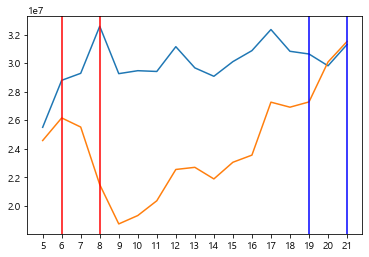

In [738]:
# 사용할 데이터만 추려내기
card_sep = card[['year','month', 'day','week_num','USE_AMT', 'USE_CNT']]

# 2019년, 2020년 카드 데이터 나누기
card_sep_2019 = card_sep[card_sep['year'] == 2019]
card_sep_2020 = card_sep[card_sep['year'] == 2020]

# 월/일/주차를 기준으로 카드 매출의 합산량을 구함.
card_sep_2019_group = card_sep_2019.pivot_table(index = ['month', 'day', 'week_num'], values='USE_AMT', aggfunc='sum').reset_index()
card_sep_2020_group = card_sep_2020.pivot_table(index = ['month', 'day', 'week_num'], values='USE_AMT', aggfunc='sum').reset_index()

# 각 일별 카드 매출의 3일 이동평균값을 계산
# why? 주차별로 비교하기 위해 토-일 전체의 데이터가 없는 
# 2019년 4주차, 2020년 4, 22주차의 데이터를 걸러내기 위함
card_sep_2019_group['rolling'] = card_sep_2019_group['USE_AMT'].rolling(window=3).mean()
card_sep_2020_group['rolling'] = card_sep_2020_group['USE_AMT'].rolling(window=3).mean()

# 주차별 이동평균 값의 평균값 산출
card_sep_2019_week = card_sep_2019_group.groupby("week_num")['rolling'].mean()
card_sep_2020_week = card_sep_2020_group.groupby("week_num")['rolling'].mean()

# 그래프 그리기
plt.plot(card_sep_2019_week[1:])
plt.plot(card_sep_2020_week[1:-1])

plt.xticks(range(5,22))
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

plt.axvline(x=19, color='blue')
plt.axvline(x=21, color='blue')

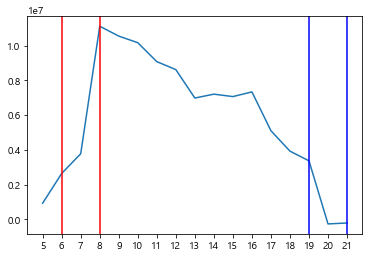

In [741]:
plt.plot(card_sep_2019_week[1:] - card_sep_2020_week[1:-1])
plt.xticks(range(5,22))
# 매출이 확 줄어드는 시기
# 이후 점점 회복세
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

# 매출이 급증하며 기본 카드매출을 따라잡는 구간
# 새로운 경제의 트랜드를 나타내는 시기가 아닐까 싶음
plt.axvline(x=19, color='blue')
plt.axvline(x=21, color='blue')

이를 근거로 카드 매출이 급감한 6-8주차 -> 소비 위축

9주차 부터 점점 소비활동이 정상 범주로 돌아오고 있음

변화의 기울기로 볼때 19-21주차에 소비가 안정되고 기존 카드 매출액을 따라 잡으며
새로운 소비형태를 보여줄 수 있는 시기라고 생각

## 방향성 : 6-8 주차의 유동인구 & 물류의 변화율을 바탕으로 특징별 집단을 나눈 뒤, 새로운 소비 트랜드가 부상했다고 생각하는 19-21주차의 집단별 각 년도의 매출 데이터를 분석하면 뉴노멀 트랜드를 잡을 수 있지 않을까 싶음

19년도(19년 6-8 각 주차 평균 = 100p) 대비 2020년 6-8주차의 유동인구 상대 크기를 나타내는 "유동 지수"

(유동인구의 감소가 일반적인 현상일 수 있기때문에 이를 보정해주고자 함)

In [90]:
# 일 ~ 토를 한 주 기준으로 보고 총 주차 데이터가 부족한 2019년 4주, 2020년 4주, 22주는 분석에서 제외
# 2019년 4주 인덱스 추출
week_index_201904 = sk[(sk['year'] == 2019) & (sk['week_num'] == 4)].index.tolist()
# 2020년 4주 인덱스 추출
week_index_202004 = sk[(sk['year'] == 2020) & (sk['week_num'] == 4)].index.tolist()
# 2020년 22주 인덱스 추출
week_index_202022 = sk[(sk['year'] == 2020) & (sk['week_num'] == 22)].index.tolist()

remove_index = week_index_201904 + week_index_202004 + week_index_202022

# 전체 데이터에서 제거
sk = sk.drop(remove_index,axis=0).reset_index(drop=True)

In [91]:
# 유동인구를 나타내는 칼럼들
num_columns = ['MAN_FLOW_POP_CNT_0004',
       'MAN_FLOW_POP_CNT_0509', 'MAN_FLOW_POP_CNT_1014',
       'MAN_FLOW_POP_CNT_1519', 'MAN_FLOW_POP_CNT_2024',
       'MAN_FLOW_POP_CNT_2529', 'MAN_FLOW_POP_CNT_3034',
       'MAN_FLOW_POP_CNT_3539', 'MAN_FLOW_POP_CNT_4044',
       'MAN_FLOW_POP_CNT_4549', 'MAN_FLOW_POP_CNT_5054',
       'MAN_FLOW_POP_CNT_5559', 'MAN_FLOW_POP_CNT_6064',
       'MAN_FLOW_POP_CNT_6569', 'MAN_FLOW_POP_CNT_70U',
       'WMAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0509',
       'WMAN_FLOW_POP_CNT_1014', 'WMAN_FLOW_POP_CNT_1519',
       'WMAN_FLOW_POP_CNT_2024', 'WMAN_FLOW_POP_CNT_2529',
       'WMAN_FLOW_POP_CNT_3034', 'WMAN_FLOW_POP_CNT_3539',
       'WMAN_FLOW_POP_CNT_4044', 'WMAN_FLOW_POP_CNT_4549',
       'WMAN_FLOW_POP_CNT_5054', 'WMAN_FLOW_POP_CNT_5559',
       'WMAN_FLOW_POP_CNT_6064', 'WMAN_FLOW_POP_CNT_6569',
       'WMAN_FLOW_POP_CNT_70U']

In [92]:
# 유동인구의 합 계산
sk['sum_flow'] = sk[num_columns].sum(axis=1)

sk_index = sk.pivot_table(index=['week_num', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM','year'], values='sum_flow', aggfunc='mean').reset_index()
sk_index

,week_num,CTPV_NM,CTGG_NM,HDNG_NM,year,sum_flow
0,5,대구광역시,수성구,고산1동,2019,118568.932857
1,5,대구광역시,수성구,고산1동,2020,127793.490000
2,5,대구광역시,수성구,고산2동,2019,257585.752857
3,5,대구광역시,수성구,고산2동,2020,223774.784286
4,5,대구광역시,수성구,고산3동,2019,50371.937143
...,...,...,...,...,...,...
2307,21,서울특별시,중구,필동,2020,99121.381429
2308,21,서울특별시,중구,황학동,2019,55119.603333
2309,21,서울특별시,중구,황학동,2020,47788.310000
2310,21,서울특별시,중구,회현동,2019,277022.720000


In [93]:
sk_index_2019 = sk_index[sk_index['year'] == 2019]
sk_index_2020 = sk_index[sk_index['year'] == 2020]
sk_index = sk_index_2019.merge(sk_index_2020, how='inner', on = ['week_num', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM'])

In [94]:
from matplotlib import font_manager, rc
import platform 

# 한글 폰트 사용
if platform.system() == 'Windows': 
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')

# 전체적인 유동인구의 경향성

In [95]:
sk_index.columns = ['week_num', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM', 'year_2019', 'sum_flow_2019',
       'year_2020', 'sum_flow_2020']

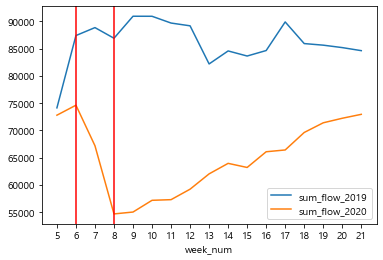

In [96]:
sk_index.groupby("week_num")['sum_flow_2019'].mean().plot()
sk_index.groupby("week_num")['sum_flow_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

# 서울/대구 분리

In [97]:
sk_index_seoul = sk_index[sk_index['CTPV_NM'] == '서울특별시']
sk_index_daegu = sk_index[sk_index['CTPV_NM'] == '대구광역시']

## 서울의 유동인구부터 보기

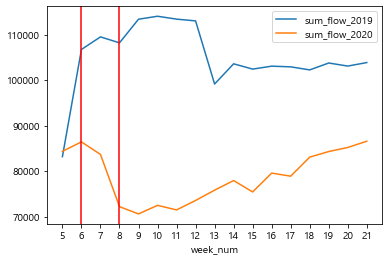

In [98]:
sk_index_seoul.groupby("week_num")['sum_flow_2019'].mean().plot()
sk_index_seoul.groupby("week_num")['sum_flow_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

## 대구의 유동인구

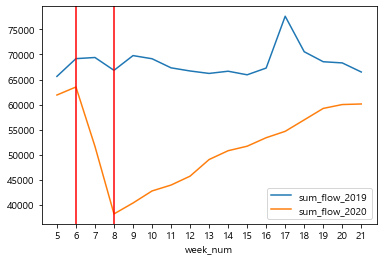

In [99]:
sk_index_daegu.groupby("week_num")['sum_flow_2019'].mean().plot()
sk_index_daegu.groupby("week_num")['sum_flow_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

## 유동인구 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 유동인구 지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [100]:
sk_index['flow_index'] = (sk_index['sum_flow_2020'] * 100) / sk_index['sum_flow_2019']

## 평균적인 유동인구 지수

In [101]:
sk_index_seoul = sk_index[sk_index['CTPV_NM'] == '서울특별시']
sk_index_daegu = sk_index[sk_index['CTPV_NM'] == '대구광역시']

### 확실히 대구가 더 낮아진 모습

In [102]:
sk_index['flow_index'].mean()

79.46200469053284

In [103]:
sk_index_seoul['flow_index'].mean()

80.7765864380025

In [104]:
sk_index_daegu['flow_index'].mean()

78.22254190006133

### 전체말고 보고싶은 6-8 주차의 유동인구만을 봐보자

In [105]:
sk_index_sep = sk_index[sk_index['week_num'].isin(range(6,9))]
sk_index_sep_seoul = sk_index_sep[sk_index_sep['CTPV_NM'] == '서울특별시']
sk_index_sep_daegu = sk_index_sep[sk_index_sep['CTPV_NM'] == '대구광역시']

In [106]:
sk_index_sep['flow_index'].mean()

78.79471646217192

In [107]:
# 시별로 살펴보기
sk_index_sep.groupby("CTPV_NM")['flow_index'].mean()

CTPV_NM
대구광역시    77.166763
서울특별시    80.521334
Name: flow_index, dtype: float64

### -> 마찬가지로 6-8주차에 대구의 유동인구가 더 많이 감소한 모습

## 서울/대구 구별로 살펴보기

In [108]:
sk_index_sep_seoul['flow_index'].mean()

80.52133424651953

In [109]:
# 서울의 구별
sk_index_sep_seoul.groupby("CTGG_NM")['flow_index'].mean()

CTGG_NM
노원구    81.808232
중구     78.774830
Name: flow_index, dtype: float64

유동인구량의 감소율의 총 량 : 80.521334 인데 비해

노원구는 줄긴했으나 총 변동률 대비 별로 안줄어들었고, 중구는 총 변동률보다 많이 줄어든 모습이다.

-> 유동인구의 타격은 중구 > 노원구

In [110]:
sk_index_sep_daegu['flow_index'].mean()

77.16676255121554

In [111]:
sk_index_sep_daegu.groupby("CTGG_NM")['flow_index'].mean()

CTGG_NM
수성구    80.967846
중구     69.881353
Name: flow_index, dtype: float64

대구의 경우 수성구보다 중구가 유동인구의 타격을 엄청 많이본 모습

## 시각화 함수

In [112]:
def plot_region_dong_sensitivity(df, x_axis, gu_name, line, rot_x = True, show_xlabel = True):
    plt.figure(figsize=(18, 6))
    
    pal = sns.color_palette("Blues_r", df.shape[0])
    
    top_down_index = df['flow_index'].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index]['HDNG_NM'].values
    sns.barplot(x = x_axis, y='flow_index', data=df, order=plot_order)
    plt.axhline(line)
    df = df.sort_values(by="flow_index", ascending=False)
    df['flow_index'] = np.round(df['flow_index'],2)
    for idx, score in enumerate(df['flow_index']):
        plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

## 동별로 살펴보자

In [113]:
# 서울 구별로 나눈 데이터
sk_index_sep_seoul_nowon = sk_index_sep_seoul[sk_index_sep_seoul['CTGG_NM'] == '노원구']
sk_index_sep_seoul_junggu = sk_index_sep_seoul[sk_index_sep_seoul['CTGG_NM'] == '중구']

# 대구 구별로 나눈 데이터
sk_index_sep_daegu_suseong = sk_index_sep_daegu[sk_index_sep_daegu['CTGG_NM'] == '수성구']
sk_index_sep_daegu_junggu = sk_index_sep_daegu[sk_index_sep_daegu['CTGG_NM'] == '중구']

In [114]:
sk_index_sep_seoul_nowon['flow_index'].mean()

81.80823180124833

##  서울 - 노원구

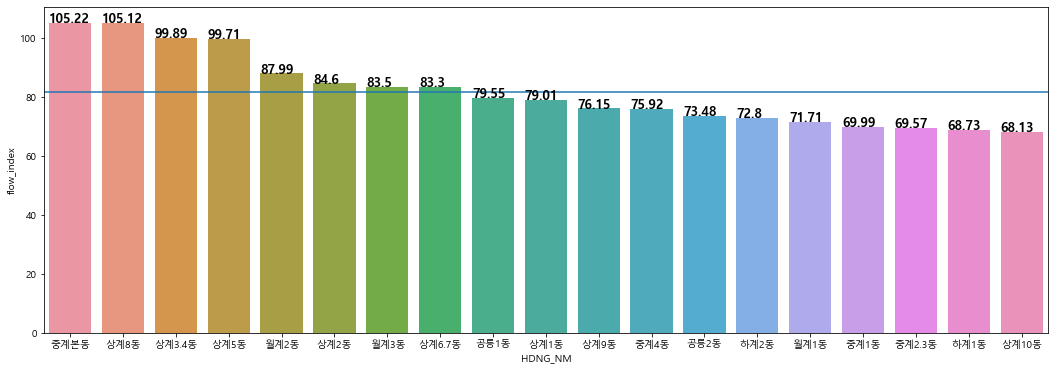

In [115]:
# 서울노원구
nowon_index = sk_index_sep_seoul_nowon.pivot_table(index='HDNG_NM', values='flow_index', aggfunc='mean')
nowon_index.reset_index(inplace=True)
plot_region_dong_sensitivity(nowon_index, 'HDNG_NM', '노원구', sk_index_sep_seoul_nowon['flow_index'].mean())

## 서울 - 중구

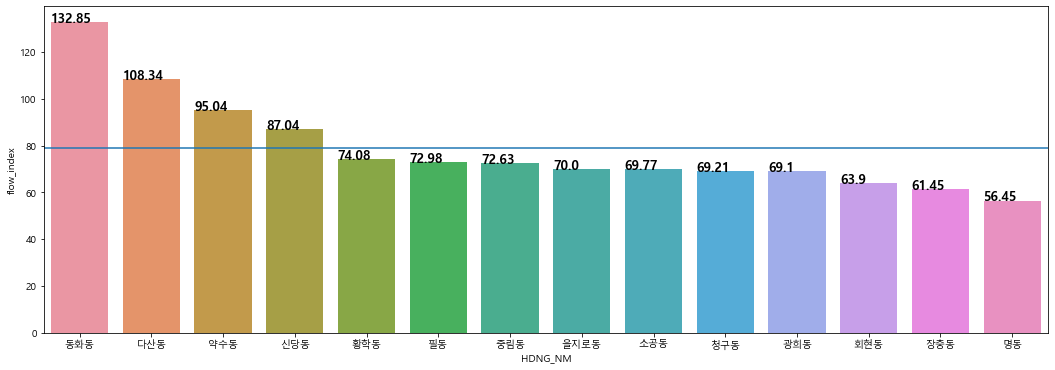

In [116]:
# 서울중구
junggu_index = sk_index_sep_seoul_junggu.pivot_table(index='HDNG_NM', values='flow_index', aggfunc='mean')
junggu_index.reset_index(inplace=True)
plot_region_dong_sensitivity(junggu_index, 'HDNG_NM', '중구', sk_index_sep_seoul_junggu['flow_index'].mean())

## 대구 - 수성구

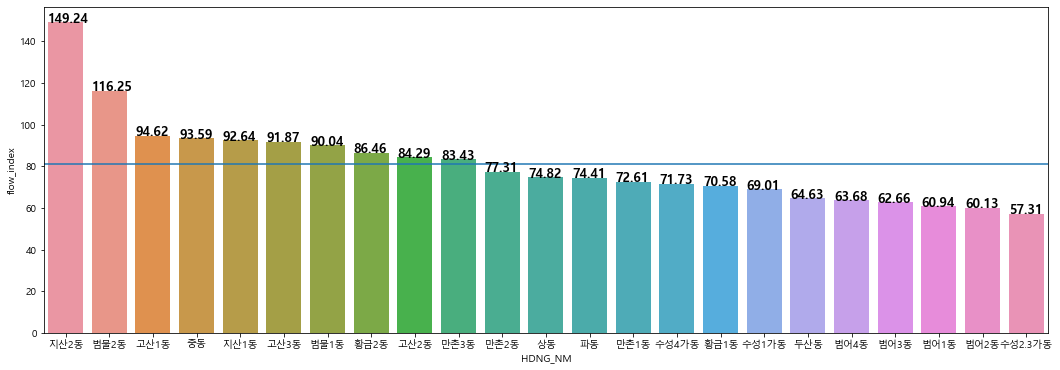

In [117]:
# 대구수성구
suseong_index = sk_index_sep_daegu_suseong.pivot_table(index='HDNG_NM', values='flow_index', aggfunc='mean')
suseong_index.reset_index(inplace=True)
plot_region_dong_sensitivity(suseong_index, 'HDNG_NM', '수성구', sk_index_sep_daegu_suseong['flow_index'].mean())

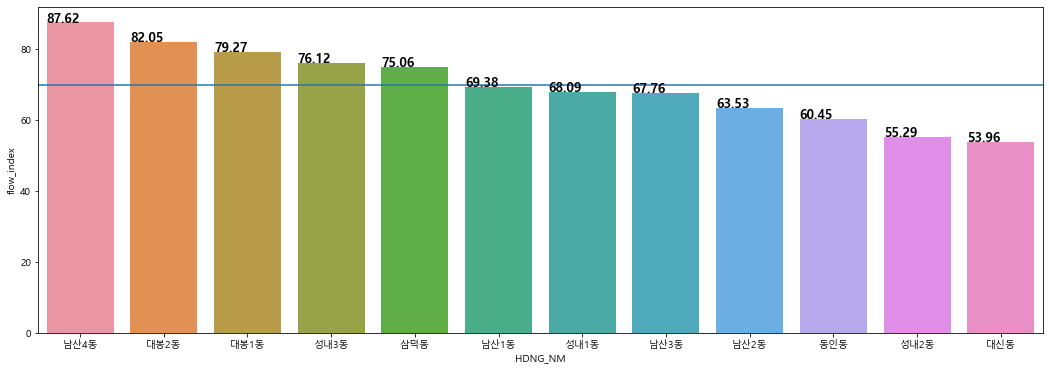

In [118]:
# 대구중구
junggu_index = sk_index_sep_daegu_junggu.pivot_table(index='HDNG_NM', values='flow_index', aggfunc='mean')
junggu_index.reset_index(inplace=True)
plot_region_dong_sensitivity(junggu_index, 'HDNG_NM', '중구', sk_index_sep_daegu_junggu['flow_index'].mean())

## -> 이를 바탕으로 물류지수와 합쳐 집단을 나누고자함

In [119]:
# 일 ~ 토를 한 주 기준으로 보고 총 주차 데이터가 부족한 2019년 4주, 2020년 4주, 22주는 분석에서 제외
# 2019년 4주 인덱스 추출
week_index_201904 = cj[(cj['year'] == 2019) & (cj['week_num'] == 4)].index.tolist()
# 2020년 4주 인덱스 추출
week_index_202004 = cj[(cj['year'] == 2020) & (cj['week_num'] == 4)].index.tolist()
# 2020년 22주 인덱스 추출
week_index_202022 = cj[(cj['year'] == 2020) & (cj['week_num'] == 22)].index.tolist()

remove_index = week_index_201904 + week_index_202004 + week_index_202022

# 전체 데이터에서 제거
cj = cj.drop(remove_index,axis=0).reset_index(drop=True)

In [120]:
cj_index = cj.pivot_table(index=['week_num', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM','year'], values = 'INVC_CONT', aggfunc='mean').reset_index()

In [121]:
cj_index

,week_num,CTPV_NM,CTGG_NM,HDNG_NM,year,INVC_CONT
0,5,대구광역시,수성구,고산1동,2019,162.130435
1,5,대구광역시,수성구,고산1동,2020,178.188406
2,5,대구광역시,수성구,고산2동,2019,122.822222
3,5,대구광역시,수성구,고산2동,2020,155.058824
4,5,대구광역시,수성구,고산3동,2019,177.377778
...,...,...,...,...,...,...
2341,21,서울특별시,중구,필동,2020,79.045455
2342,21,서울특별시,중구,황학동,2019,124.741379
2343,21,서울특별시,중구,황학동,2020,145.521739
2344,21,서울특별시,중구,회현동,2019,143.266667


In [122]:
cj_index_2019 = cj_index[cj_index['year'] == 2019]
cj_index_2020 = cj_index[cj_index['year'] == 2020]
cj_index = cj_index_2019.merge(cj_index_2020, how='inner', on = ['week_num', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM'])

In [123]:
cj_index.columns = ['week_num', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM', 'year_2019', 'INVC_CONT_2019',
       'year_2020', 'INVC_CONT_2020']

# 전체적인 물류의 경향성

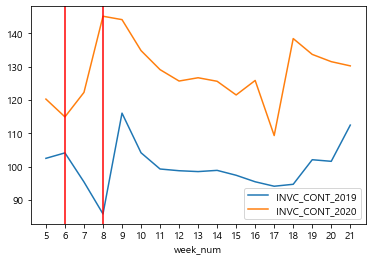

In [124]:
cj_index.groupby("week_num")['INVC_CONT_2019'].mean().plot()
cj_index.groupby("week_num")['INVC_CONT_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

# 서울/대구 분리

In [125]:
cj_index_seoul = cj_index[cj_index['CTPV_NM'] == '서울특별시']
cj_index_daegu = cj_index[cj_index['CTPV_NM'] == '대구광역시']

## 서울의 물류부터 보기

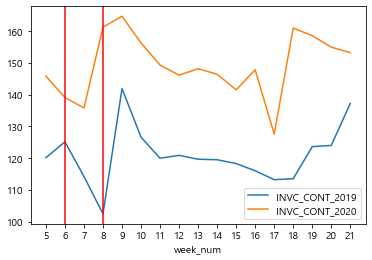

In [126]:
cj_index_seoul.groupby("week_num")['INVC_CONT_2019'].mean().plot()
cj_index_seoul.groupby("week_num")['INVC_CONT_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

## 대구의 물류

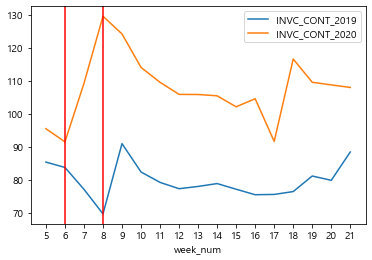

In [127]:
cj_index_daegu.groupby("week_num")['INVC_CONT_2019'].mean().plot()
cj_index_daegu.groupby("week_num")['INVC_CONT_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

## 물류 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 물류 지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [128]:
cj_index['dist_index'] = (cj_index['INVC_CONT_2020'] * 100) / cj_index['INVC_CONT_2019']

## 평균적인 물류 지수

In [129]:
cj_index_seoul = cj_index[cj_index['CTPV_NM'] == '서울특별시']
cj_index_daegu = cj_index[cj_index['CTPV_NM'] == '대구광역시']

In [130]:
cj_index['dist_index'].mean()

129.68528000222815

In [131]:
cj_index_seoul['dist_index'].mean()

124.43342489777896

In [132]:
cj_index_daegu['dist_index'].mean()

134.78708210369325

### 유동인구때와 마찬가지로 대구의 물류지수가 훨씬 높음

### 전체말고 보고싶은 6-8 주차의 물류만을 봐보자

In [133]:
cj_index_sep = cj_index[cj_index['week_num'].isin(range(6,9))]
cj_index_sep_seoul = cj_index_sep[cj_index_sep['CTPV_NM'] == '서울특별시']
cj_index_sep_daegu = cj_index_sep[cj_index_sep['CTPV_NM'] == '대구광역시']

In [134]:
cj_index_sep['dist_index'].mean()

137.08221107304652

In [135]:
# 시별로 살펴보기
cj_index_sep.groupby("CTPV_NM")['dist_index'].mean()

CTPV_NM
대구광역시    144.391559
서울특별시    129.557883
Name: dist_index, dtype: float64

### -> 마찬가지로 6-8주차에 대구의 유동인구가 더 증가한 모습

## 서울/대구 구별로 살펴보기

In [136]:
cj_index_sep_seoul['dist_index'].mean()

129.55788270416573

In [137]:
# 서울의 구별
cj_index_sep_seoul.groupby("CTGG_NM")['dist_index'].mean()

CTGG_NM
노원구    133.086443
중구     125.088372
Name: dist_index, dtype: float64

물류지수의 총 량 : 129.55788270416573 인데 비해

노원구가 133으로 더 높아서 물류를 더 많이시키는 모습이고
중구는 작년도에 비해 오르긴했지만 서울의 평균은 못따라감.

In [138]:
cj_index_sep_daegu['dist_index'].mean()

144.39155863138785

In [139]:
cj_index_sep_daegu.groupby("CTGG_NM")['dist_index'].mean()

CTGG_NM
수성구    151.270814
중구     131.206319
Name: dist_index, dtype: float64

대구의 경우 유동인구 타격을 덜받았던 수성구가 택배를 훨씬 많이시킴

## 시각화 함수

In [140]:
def plot_region_dong_sensitivity(df, x_axis, gu_name, line, rot_x = True, show_xlabel = True):
    plt.figure(figsize=(18, 6))
    
    pal = sns.color_palette("Blues_r", df.shape[0])
    
    top_down_index = df['dist_index'].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index]['HDNG_NM'].values
    sns.barplot(x = x_axis, y='dist_index', data=df, order=plot_order)
    plt.axhline(line)
    df = df.sort_values(by="dist_index", ascending=False)
    df['dist_index'] = np.round(df['dist_index'],2)
    for idx, score in enumerate(df['dist_index']):
        plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

## 동별로 살펴보자

In [141]:
# 서울 구별로 나눈 데이터
cj_index_sep_seoul_nowon = cj_index_sep_seoul[cj_index_sep_seoul['CTGG_NM'] == '노원구']
cj_index_sep_seoul_junggu = cj_index_sep_seoul[cj_index_sep_seoul['CTGG_NM'] == '중구']

# 대구 구별로 나눈 데이터
cj_index_sep_daegu_suseong = cj_index_sep_daegu[cj_index_sep_daegu['CTGG_NM'] == '수성구']
cj_index_sep_daegu_junggu = cj_index_sep_daegu[cj_index_sep_daegu['CTGG_NM'] == '중구']

In [142]:
cj_index_sep_seoul_nowon['dist_index'].mean()

133.08644339751407

##  서울 - 노원구

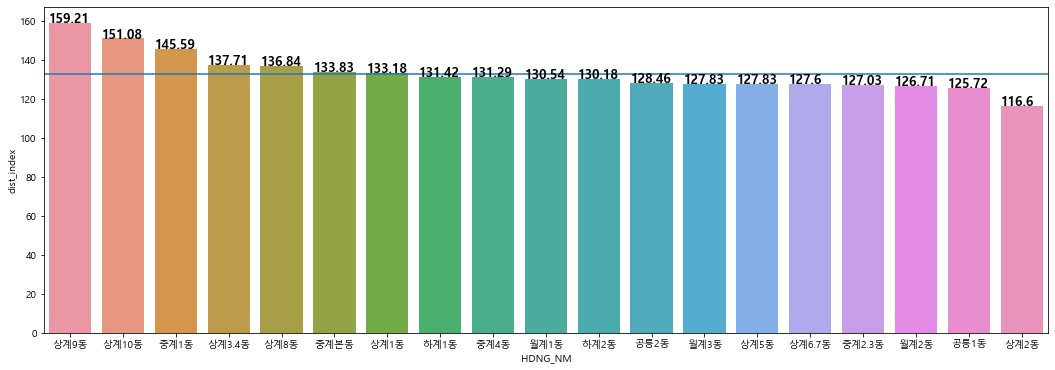

In [143]:
# 서울노원구
nowon_index = cj_index_sep_seoul_nowon.pivot_table(index='HDNG_NM', values='dist_index', aggfunc='mean')
nowon_index.reset_index(inplace=True)
plot_region_dong_sensitivity(nowon_index, 'HDNG_NM', '노원구', cj_index_sep_seoul_nowon['dist_index'].mean())

--> 대충 집단을 보자면 유동인구가 굉장히 민감했던 상계10동, 중계 1동 등이 상위에 포진되어있음

## 서울 - 중구

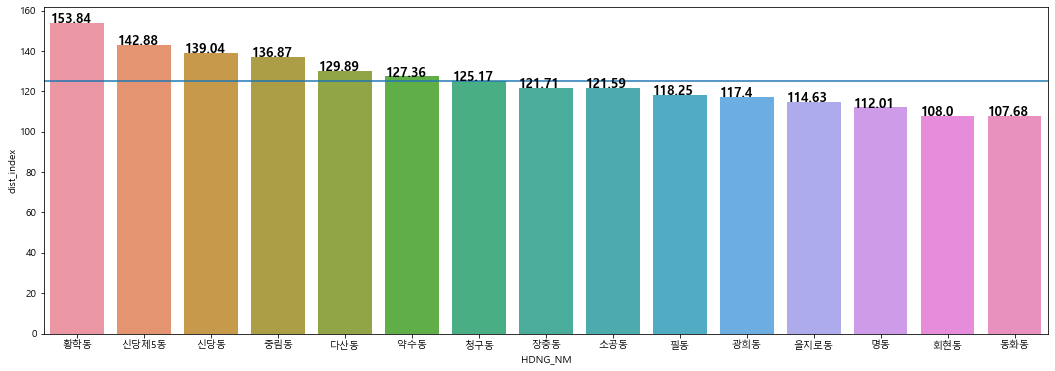

In [144]:
# 서울중구
junggu_index = cj_index_sep_seoul_junggu.pivot_table(index='HDNG_NM', values='dist_index', aggfunc='mean')
junggu_index.reset_index(inplace=True)
plot_region_dong_sensitivity(junggu_index, 'HDNG_NM', '중구', cj_index_sep_seoul_junggu['dist_index'].mean())

## 대구 - 수성구

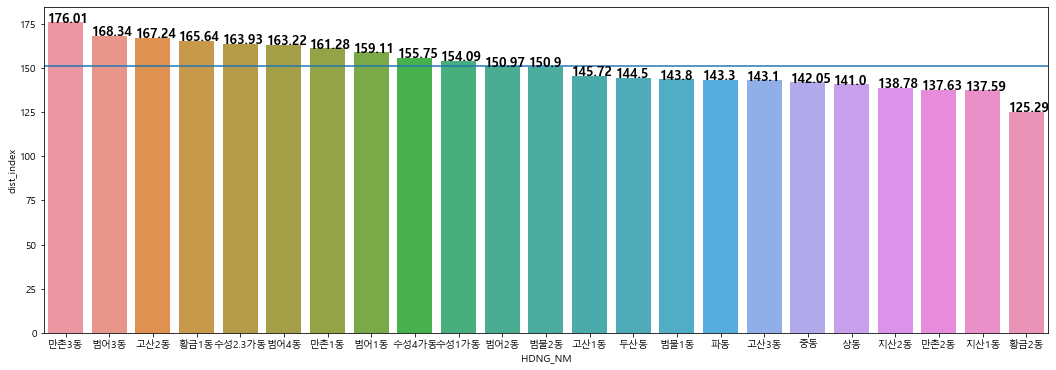

In [145]:
# 대구수성구
suseong_index = cj_index_sep_daegu_suseong.pivot_table(index='HDNG_NM', values='dist_index', aggfunc='mean')
suseong_index.reset_index(inplace=True)
plot_region_dong_sensitivity(suseong_index, 'HDNG_NM', '수성구', cj_index_sep_daegu_suseong['dist_index'].mean())

## 대구 - 중구

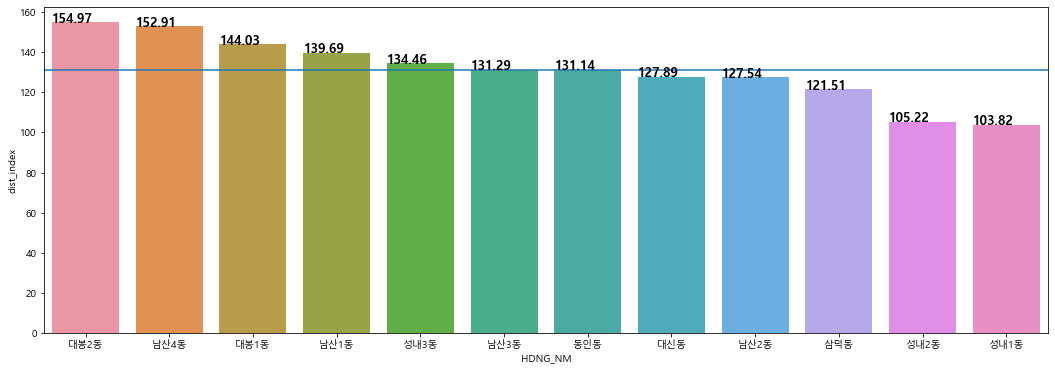

In [146]:
# 대구중구
junggu_index = cj_index_sep_daegu_junggu.pivot_table(index='HDNG_NM', values='dist_index', aggfunc='mean')
junggu_index.reset_index(inplace=True)
plot_region_dong_sensitivity(junggu_index, 'HDNG_NM', '중구', cj_index_sep_daegu_junggu['dist_index'].mean())

## 이 지수를 바탕으로 집단을 나누고자함!

## +추가 (09/13) 유통지수도 보자!

In [33]:
# 일 ~ 토를 한 주 기준으로 보고 총 주차 데이터가 부족한 2019년 4주, 2020년 4주, 22주는 분석에서 제외
# 2019년 4주 인덱스 추출
week_index_201904 = gs[(gs['year'] == 2019) & (gs['week_num'] == 4)].index.tolist()
# 2020년 4주 인덱스 추출
week_index_202004 = gs[(gs['year'] == 2020) & (gs['week_num'] == 4)].index.tolist()
# 2020년 22주 인덱스 추출
week_index_202022 = gs[(gs['year'] == 2020) & (gs['week_num'] == 22)].index.tolist()

remove_index = week_index_201904 + week_index_202004 + week_index_202022

# 전체 데이터에서 제거
gs = gs.drop(remove_index,axis=0).reset_index(drop=True)

In [35]:
# 주차별 유동지수 트랜드 테이블 생성
gs_index = gs.pivot_table(index=['week_num', 'PVN', 'BOR', 'ADMD', 'year'], values = 'AMT_IND', aggfunc='mean').reset_index()

In [36]:
gs_index

,week_num,PVN,BOR,ADMD,year,AMT_IND
0,5,대구광역시,수성구,고산1동,2019,0.915240
1,5,대구광역시,수성구,고산1동,2020,0.820941
2,5,대구광역시,수성구,고산2동,2019,1.241280
3,5,대구광역시,수성구,고산2동,2020,1.072548
4,5,대구광역시,수성구,고산3동,2019,0.878115
...,...,...,...,...,...,...
2035,21,서울특별시,중구,필동,2020,1.125473
2036,21,서울특별시,중구,황학동,2019,1.145948
2037,21,서울특별시,중구,황학동,2020,1.121260
2038,21,서울특별시,중구,회현동,2019,1.698512


In [38]:
gs_index_2019 = gs_index[gs_index['year'] == 2019]
gs_index_2020 = gs_index[gs_index['year'] == 2020]
gs_index = gs_index_2019.merge(gs_index_2020, how='inner', on = ['week_num', 'PVN', 'BOR', 'ADMD'])

In [39]:
from matplotlib import font_manager, rc
import platform 

# 한글 폰트 사용
if platform.system() == 'Windows': 
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')

## 전체적인 유통지수의 경향성

In [41]:
# 전처리를 통해서 유통지수의 칼럼도 비슷하게 맞춰줌
gs_index.columns = ['week_num', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM', 'year_2019', 'conv_index_2019',
       'year_2020', 'conv_index_2020']

In [42]:
gs_index

,week_num,CTPV_NM,CTGG_NM,HDNG_NM,year_2019,conv_index_2019,year_2020,conv_index_2020
0,5,대구광역시,수성구,고산1동,2019,0.915240,2020,0.820941
1,5,대구광역시,수성구,고산2동,2019,1.241280,2020,1.072548
2,5,대구광역시,수성구,고산3동,2019,0.878115,2020,0.688218
3,5,대구광역시,수성구,두산동,2019,0.892053,2020,0.819222
4,5,대구광역시,수성구,만촌1동,2019,1.217140,2020,1.091757
...,...,...,...,...,...,...,...,...
1015,21,서울특별시,중구,중림동,2019,1.132603,2020,1.204121
1016,21,서울특별시,중구,청구동,2019,1.417156,2020,1.370895
1017,21,서울특별시,중구,필동,2019,1.606599,2020,1.125473
1018,21,서울특별시,중구,황학동,2019,1.145948,2020,1.121260


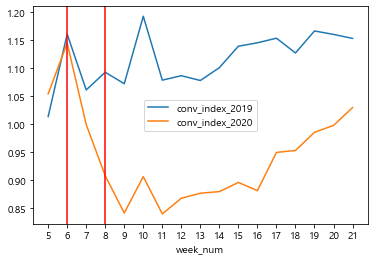

In [43]:
gs_index.groupby("week_num")['conv_index_2019'].mean().plot()
gs_index.groupby("week_num")['conv_index_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

### 원래 5-6주차가 올라가고 6-7주차가 떨어지는진 모르겠지만 7-/8주차때 오른 2019년에 비해 2020년은 대폭 하락

# 서울/대구 분리

In [44]:
gs_index_seoul = gs_index[gs_index['CTPV_NM'] == '서울특별시']
gs_index_daegu = gs_index[gs_index['CTPV_NM'] == '대구광역시']

## 서울의 유통부터 보기

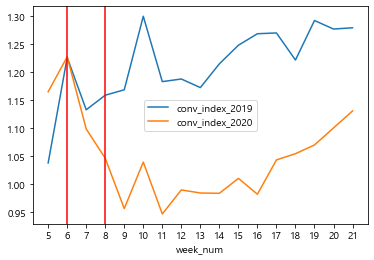

In [45]:
gs_index_seoul.groupby("week_num")['conv_index_2019'].mean().plot()
gs_index_seoul.groupby("week_num")['conv_index_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

## 대구의 유통

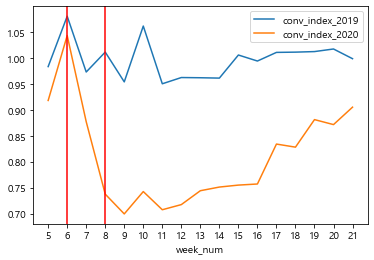

In [46]:
gs_index_daegu.groupby("week_num")['conv_index_2019'].mean().plot()
gs_index_daegu.groupby("week_num")['conv_index_2020'].mean().plot()
plt.xticks(range(5,22))
plt.legend()
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

### 대구가 더 대폭으로 하락

## 유통 변화지수 계산하기
### 2019년의 동주차를 100으로 보고 유동인구 지수 산출
(일반적으로 감소하거나 증가하는 경향을 보정해주기 위함)

In [48]:
gs_index['conv_index'] = (gs_index['conv_index_2020'] * 100) / gs_index['conv_index_2019']

## 평균적인 유통 지수

In [49]:
gs_index_seoul = gs_index[gs_index['CTPV_NM'] == '서울특별시']
gs_index_daegu = gs_index[gs_index['CTPV_NM'] == '대구광역시']

In [51]:
gs_index['conv_index'].mean()

87.31621569823137

In [52]:
gs_index_seoul['conv_index'].mean()

89.88642419034625

In [53]:
gs_index_daegu['conv_index'].mean()

84.1748497634243

## 확실히 대구가 더 낮아진 모습

### 전체말고 보고싶은 6-8 주차의 유통만을 봐보자

In [54]:
gs_index_sep = gs_index[gs_index['week_num'].isin(range(6,9))]
gs_index_sep_seoul = gs_index_sep[gs_index_sep['CTPV_NM'] == '서울특별시']
gs_index_sep_daegu = gs_index_sep[gs_index_sep['CTPV_NM'] == '대구광역시']

In [56]:
gs_index_sep['conv_index'].mean()

94.25741842015303

In [57]:
# 시별로 살펴보기
gs_index_sep.groupby("CTPV_NM")['conv_index'].mean()

CTPV_NM
대구광역시    90.188832
서울특별시    97.586262
Name: conv_index, dtype: float64

### -> 마찬가지로 6-8주차에 대구의 유통이 더 많이 감소한 모습

## 서울/대구 구별로 살펴보기

In [58]:
gs_index_sep_seoul['conv_index'].mean()

97.58626161480036

In [59]:
# 서울의 구별
gs_index_sep_seoul.groupby("CTGG_NM")['conv_index'].mean()

CTGG_NM
노원구    100.271958
중구      94.363426
Name: conv_index, dtype: float64

## 중구가 뭐든 더 타격 큼

In [61]:
gs_index_sep_daegu['conv_index'].mean()

90.1888322933618

In [62]:
gs_index_sep_daegu.groupby("CTGG_NM")['conv_index'].mean()

CTGG_NM
수성구    92.490310
중구     83.613182
Name: conv_index, dtype: float64

### 중구가 타격이 더 크다.

In [63]:
def plot_region_dong_sensitivity(df, x_axis, gu_name, line, rot_x = True, show_xlabel = True):
    plt.figure(figsize=(18, 6))
    
    pal = sns.color_palette("Blues_r", df.shape[0])
    
    top_down_index = df['conv_index'].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index]['HDNG_NM'].values
    sns.barplot(x = x_axis, y='conv_index', data=df, order=plot_order)
    plt.axhline(line)
    df = df.sort_values(by="conv_index", ascending=False)
    df['conv_index'] = np.round(df['conv_index'],2)
    for idx, score in enumerate(df['conv_index']):
        plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

In [64]:
# 서울 구별로 나눈 데이터
gs_index_sep_seoul_nowon = gs_index_sep_seoul[gs_index_sep_seoul['CTGG_NM'] == '노원구']
gs_index_sep_seoul_junggu = gs_index_sep_seoul[gs_index_sep_seoul['CTGG_NM'] == '중구']

# 대구 구별로 나눈 데이터
gs_index_sep_daegu_suseong = gs_index_sep_daegu[gs_index_sep_daegu['CTGG_NM'] == '수성구']
gs_index_sep_daegu_junggu = gs_index_sep_daegu[gs_index_sep_daegu['CTGG_NM'] == '중구']

In [66]:
gs_index_sep_seoul_nowon['conv_index'].mean()

100.27195771252227

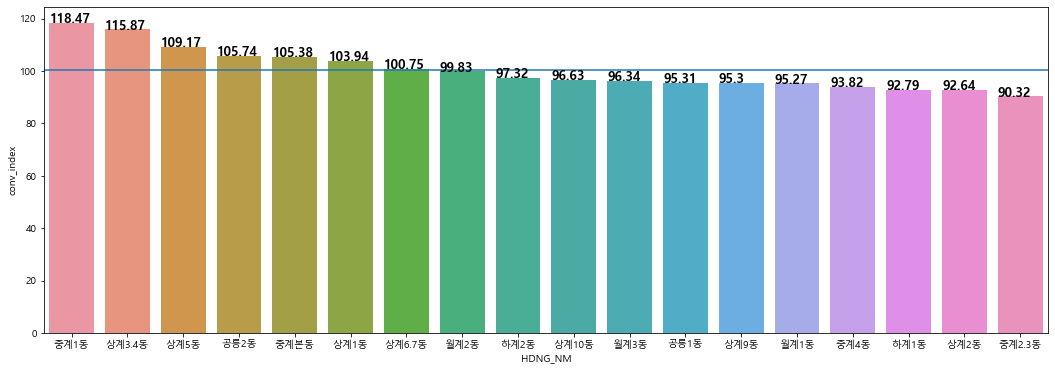

In [69]:
# 서울노원구
nowon_index = gs_index_sep_seoul_nowon.pivot_table(index='HDNG_NM', values='conv_index', aggfunc='mean')
nowon_index.reset_index(inplace=True)
plot_region_dong_sensitivity(nowon_index, 'HDNG_NM', '노원구', gs_index_sep_seoul_nowon['conv_index'].mean())

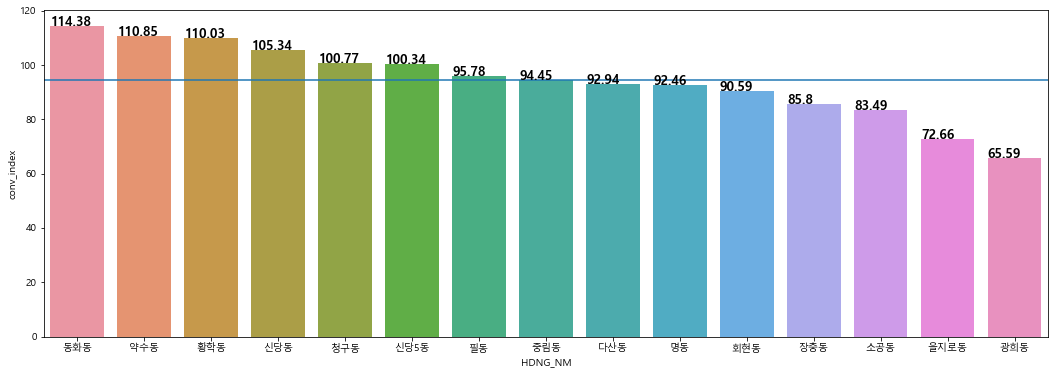

In [70]:
# 서울중구
junggu_index = gs_index_sep_seoul_junggu.pivot_table(index='HDNG_NM', values='conv_index', aggfunc='mean')
junggu_index.reset_index(inplace=True)
plot_region_dong_sensitivity(junggu_index, 'HDNG_NM', '중구', gs_index_sep_seoul_junggu['conv_index'].mean())

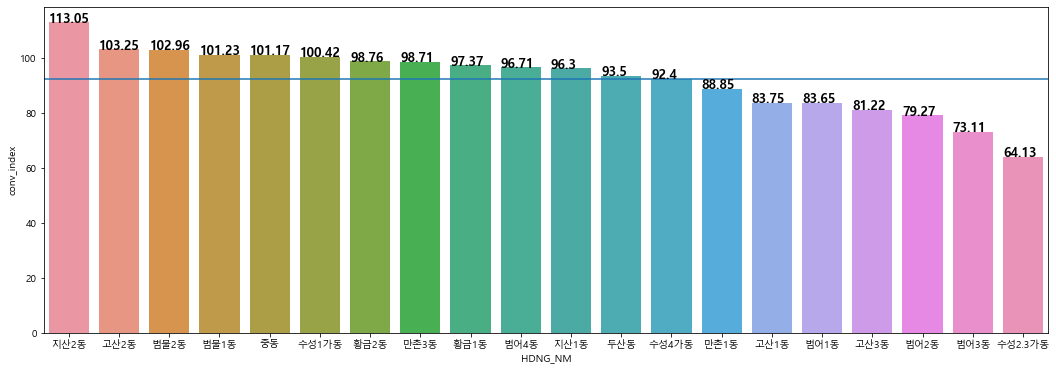

In [71]:
# 대구수성구
suseong_index = gs_index_sep_daegu_suseong.pivot_table(index='HDNG_NM', values='conv_index', aggfunc='mean')
suseong_index.reset_index(inplace=True)
plot_region_dong_sensitivity(suseong_index, 'HDNG_NM', '수성구', gs_index_sep_daegu_suseong['conv_index'].mean())

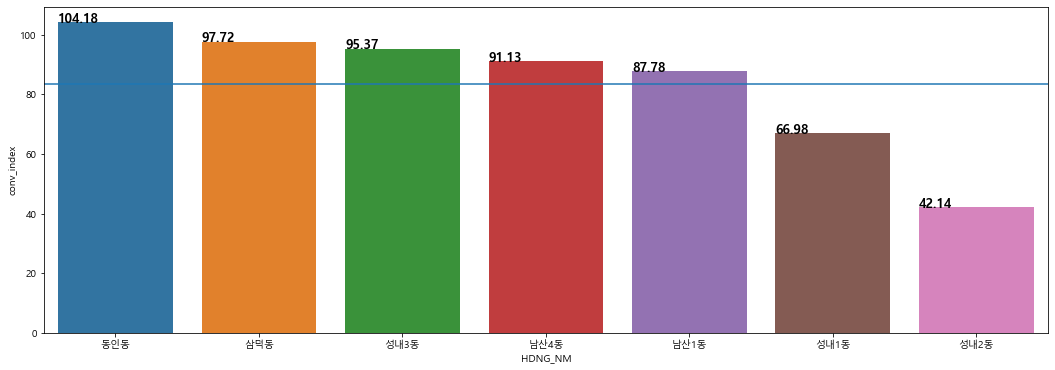

In [72]:
# 대구중구
junggu_index = gs_index_sep_daegu_junggu.pivot_table(index='HDNG_NM', values='conv_index', aggfunc='mean')
junggu_index.reset_index(inplace=True)
plot_region_dong_sensitivity(junggu_index, 'HDNG_NM', '중구', gs_index_sep_daegu_junggu['conv_index'].mean())

### -> 카드나 유동인구 데이터에서는 12개가 있는 동이 gs에서는 7개 뿐

### -> 이를 바탕으로 집단을 나눠보자

In [742]:
index_group_sk = cj_index_sep.pivot_table(index=['HDNG_NM','CTGG_NM', 'CTPV_NM'], values='dist_index', aggfunc='mean').reset_index()
index_group_cj = sk_index_sep.pivot_table(index=['HDNG_NM','CTGG_NM', 'CTPV_NM'], values='flow_index', aggfunc='mean').reset_index()
index_group_gs = gs_index_sep.pivot_table(index=['HDNG_NM','CTGG_NM', 'CTPV_NM'], values='conv_index', aggfunc='mean').reset_index()

index_group = index_group_sk.merge(index_group_cj, how='inner', on=['HDNG_NM','CTPV_NM','CTGG_NM'])
index_group = index_group.merge(index_group_gs, how='inner', on =['HDNG_NM','CTPV_NM','CTGG_NM'])

index_group

,HDNG_NM,CTGG_NM,CTPV_NM,dist_index,flow_index,conv_index
0,고산1동,수성구,대구광역시,145.719078,94.622031,83.751185
1,고산2동,수성구,대구광역시,167.243376,84.291511,103.251721
2,고산3동,수성구,대구광역시,143.095074,91.866754,81.221808
3,공릉1동,노원구,서울특별시,125.715839,79.548391,95.313061
4,공릉2동,노원구,서울특별시,128.462220,73.479819,105.741143
5,광희동,중구,서울특별시,117.401037,69.104303,65.591732
6,남산1동,중구,대구광역시,139.690406,69.377711,87.777271
7,남산4동,중구,대구광역시,152.911714,87.621221,91.132565
8,다산동,중구,서울특별시,129.892673,108.344108,92.938827
9,동인동,중구,대구광역시,131.135178,60.449072,104.177905


In [685]:
from mpl_toolkits.mplot3d import Axes3D

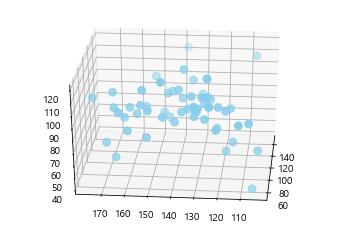

In [745]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(index_group['flow_index'] , index_group['dist_index'], index_group['conv_index'], c = 'skyblue', s =60)
ax.view_init(30, 185)
plt.show()

In [687]:
index_group['HDNG_NM'].nunique()

59

In [688]:
cj_index['HDNG_NM'].nunique()

69

In [689]:
sk_index['HDNG_NM'].nunique()

68

In [690]:
gs_index['HDNG_NM'].nunique()

60

## -> 총 69개인데 inner(교집합) 은 59개

## 2차원으로 정사영

### flow x dist

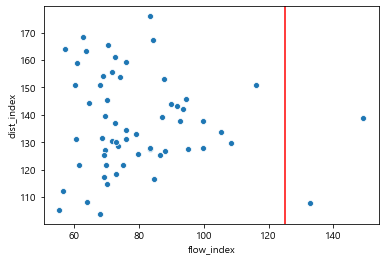

In [691]:
sns.scatterplot(index_group['flow_index'], index_group['dist_index'], data = index_group )

plt.axvline(125, color = 'red')

### flow x conv

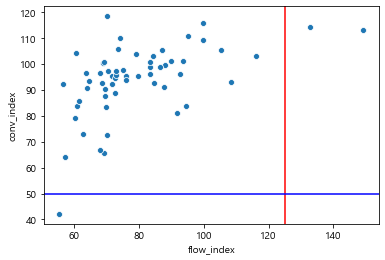

In [692]:
sns.scatterplot(index_group['flow_index'], index_group['conv_index'], data = index_group )

plt.axvline(125, color = 'red')
plt.axhline(50, color='blue')

### dist x conv

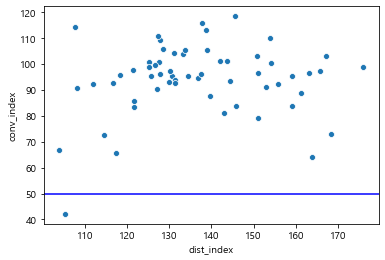

In [693]:
sns.scatterplot(index_group['dist_index'], index_group['conv_index'], data = index_group )

plt.axhline(50, color='blue')

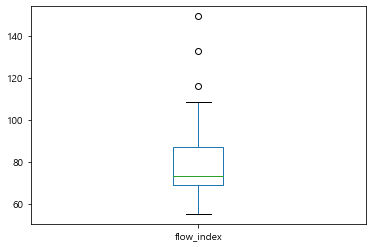

In [694]:
index_group['flow_index'].plot.box()

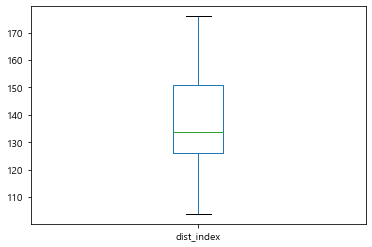

In [695]:
index_group['dist_index'].plot.box()

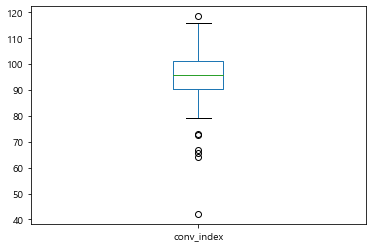

In [696]:
index_group['conv_index'].plot.box()

### 선으로 나눈 동떨어진 데이터들 제거하기

In [746]:
remove_dong_index = []

In [747]:
index_group[index_group['flow_index'] > 125]

,HDNG_NM,CTGG_NM,CTPV_NM,dist_index,flow_index,conv_index
10,동화동,중구,서울특별시,107.677445,132.849232,114.37898
50,지산2동,수성구,대구광역시,138.776336,149.244922,113.04553


In [748]:
remove_dong_index = remove_dong_index + index_group[index_group['flow_index'] > 125].index.tolist()

In [749]:
index_group[index_group['conv_index'] < 50]

,HDNG_NM,CTGG_NM,CTPV_NM,dist_index,flow_index,conv_index
30,성내2동,중구,대구광역시,105.216303,55.290494,42.136309


In [750]:
remove_dong_index = remove_dong_index + index_group[index_group['conv_index'] < 50].index.tolist()

In [751]:
remove_dong_index

[10, 50, 30]

In [752]:
index_group.drop(remove_dong_index, axis=0, inplace=True)

## -> 근거 마련 plz

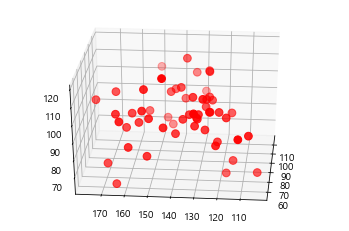

In [753]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(index_group['flow_index'] , index_group['dist_index'], index_group['conv_index'], c = 'red', s =60)
ax.view_init(30, 185)
plt.show()

## 2차원으로 정사영

### flow x dist

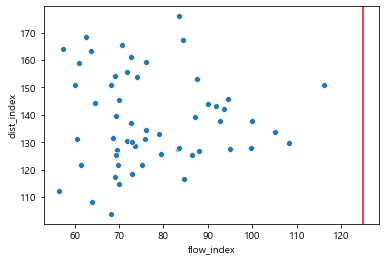

In [706]:
sns.scatterplot(index_group['flow_index'], index_group['dist_index'], data = index_group )

plt.axvline(125, color = 'red')

### flow x conv

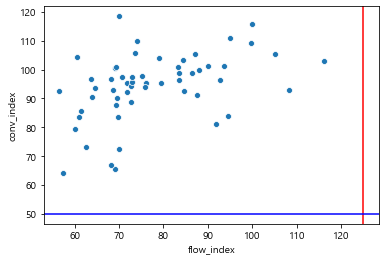

In [708]:
sns.scatterplot(index_group['flow_index'], index_group['conv_index'], data = index_group )

plt.axvline(125, color = 'red')
plt.axhline(50, color='blue')

### dist x conv

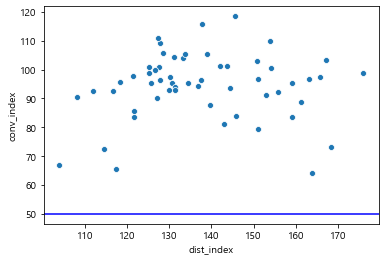

In [709]:
sns.scatterplot(index_group['dist_index'], index_group['conv_index'], data = index_group )

plt.axhline(50, color='blue')

### -> 나름 예쁘게 남은 모습 !

### 단순히 선을 그어서 나누는거보다는 근거있는 집단 선정이 필요하다 생각..

### 그리고 서울/대구를 굳이 구분안해도 될거같은게 동일한 지역의 19년 동일 주차를 100으로 잡았기때문에 그 지역의 민감성은 충분히 반영이 되었다고 생각함.


--> 군집화는 역시 clustering

In [754]:
data = index_group.set_index(['HDNG_NM', 'CTGG_NM', 'CTPV_NM'])

In [755]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)

kmeans.fit(data)

cluster = kmeans.predict(data)

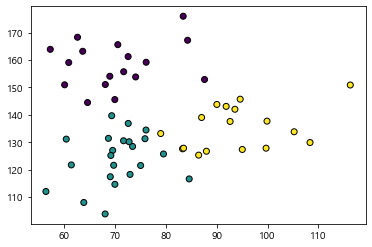

In [756]:
plt.scatter(data['flow_index'], data['dist_index'], c=cluster, linewidth=1, edgecolor='black')
plt.show()

In [757]:
from sklearn.metrics import silhouette_score

best_n = 1
best_score = -1

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(data)
    cluster = kmeans.predict(data)
    score = silhouette_score(data, cluster)
    
    print('클러스터의 수 : {}, 실루엣 점수 : {:.2f}'.format(n_cluster, score))
    if score > best_score :
        best_n = n_cluster
        best_score = score
        
print('가장 높은 실루엣 점수를 가진 클러스터 수 : {}, 실루엣 점수 : {:.2f}'.format(best_n, best_score))

클러스터의 수 : 2, 실루엣 점수 : 0.35
클러스터의 수 : 3, 실루엣 점수 : 0.35
클러스터의 수 : 4, 실루엣 점수 : 0.36
클러스터의 수 : 5, 실루엣 점수 : 0.36
클러스터의 수 : 6, 실루엣 점수 : 0.36
클러스터의 수 : 7, 실루엣 점수 : 0.30
클러스터의 수 : 8, 실루엣 점수 : 0.31
클러스터의 수 : 9, 실루엣 점수 : 0.30
클러스터의 수 : 10, 실루엣 점수 : 0.34
가장 높은 실루엣 점수를 가진 클러스터 수 : 5, 실루엣 점수 : 0.36


### 군집화를 사후검정하는 지표인 실루엣 점수가 5개의 군집일때 가장 좋음

In [758]:
# elbow 기법
def elbow(x):
    k = []
    sse = []
    
    for i in range(1, 11):
        model = KMeans(n_clusters = i)
        model.fit(x)
        sse.append(model.inertia_)
        k.append(i)
        
    plt.plot(k, sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.xticks(range(1,11))
    plt.show() 

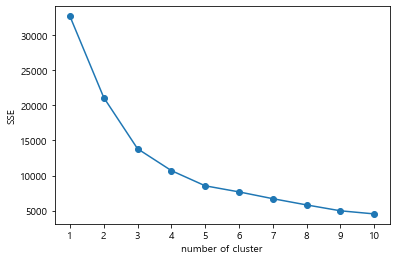

In [759]:
elbow(data)

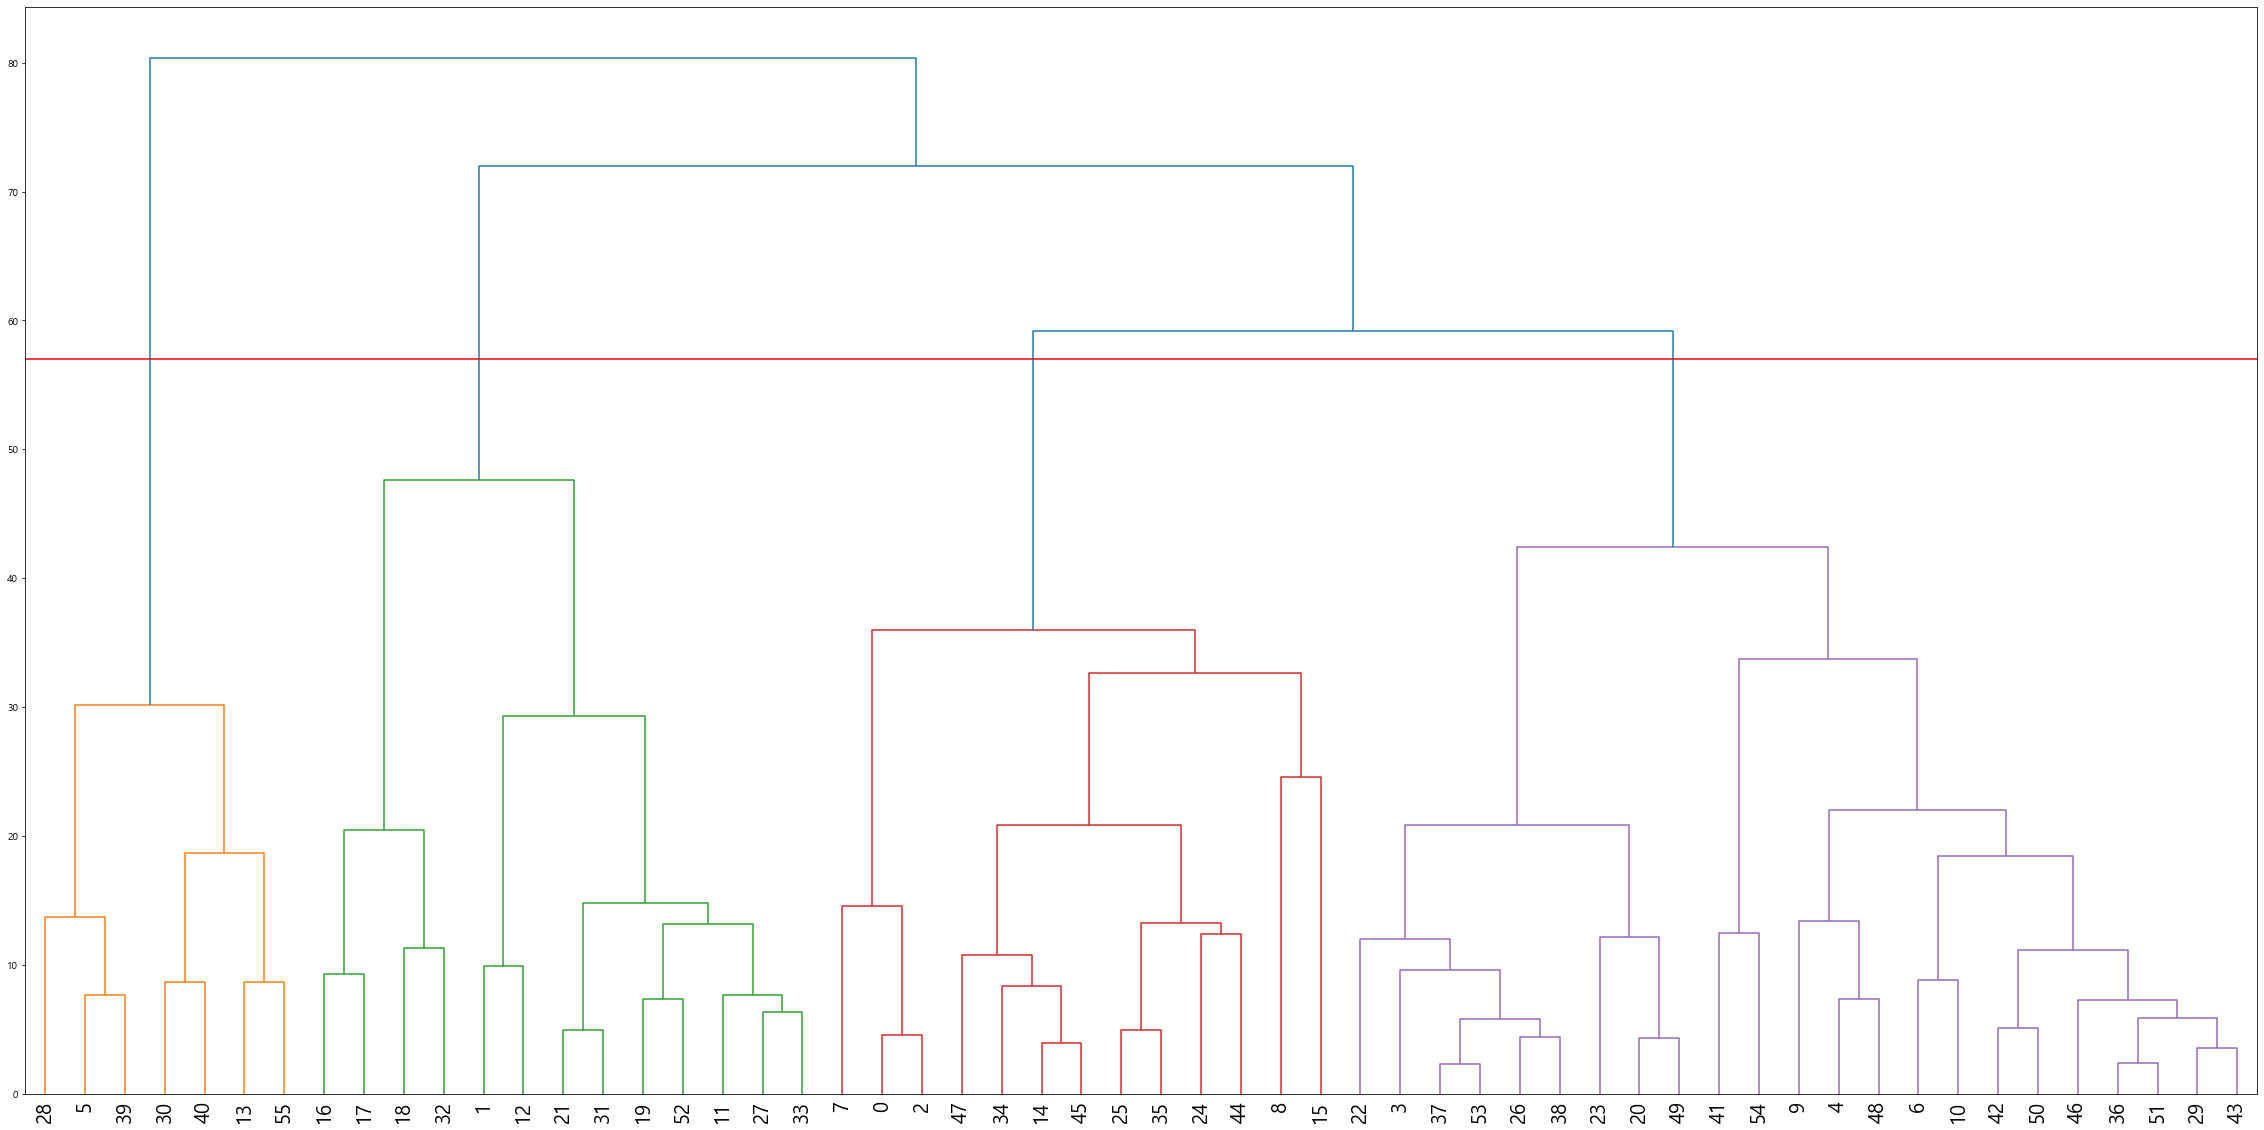

In [760]:
from scipy.cluster.hierarchy import linkage, dendrogram

# 'complete' : 먼 거리
# 'single' : 짧은 거리
# 'average' : 평균 거리

mergings = linkage(data,method='complete')

plt.figure(figsize=(40,20))
dendrogram(mergings,
           leaf_rotation=90,
           leaf_font_size=20,
)

plt.axhline(57, color = 'r')
plt.show()

## -> 4개로 나누는게 가장 합리적이어 보임

In [769]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)

kmeans.fit(data)

cluster = kmeans.predict(data)

In [770]:
cluster

array([1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 0, 2,
       0, 0, 1, 1, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 2, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 2, 1, 2, 0])

In [771]:
data['cluster'] = cluster

index_group_cluster = data.copy()

--> 3번 군집은 4개동 밖에없음

In [772]:
index_group_cluster.groupby('cluster').count()

,dist_index,flow_index,conv_index
cluster,,,
0,25,25,25
1,14,14,14
2,17,17,17


In [773]:
df = index_group_cluster.groupby("cluster")['dist_index', 'flow_index', 'conv_index'].mean()

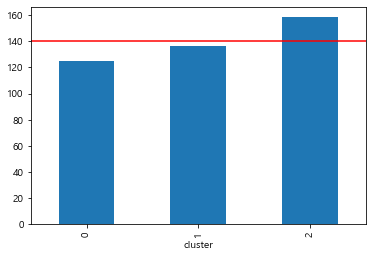

In [774]:
df['dist_index'].plot(kind='bar')
plt.axhline(df['dist_index'].mean(), color='red')

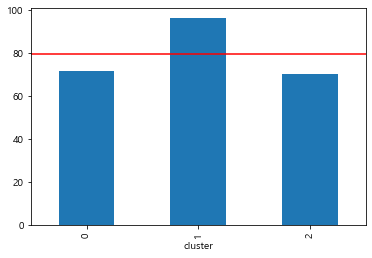

In [775]:
df['flow_index'].plot(kind='bar')
plt.axhline(df['flow_index'].mean(), color='red')

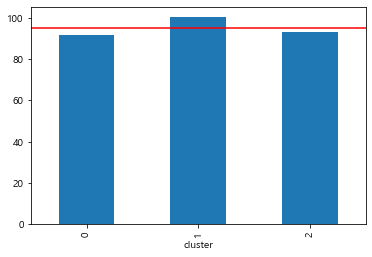

In [776]:
df['conv_index'].plot(kind='bar')
plt.axhline(df['conv_index'].mean(), color='red')

### 내가 생각하는 코로나 트랜드의 개이득 : 유동인구 줄고 물류 업

## -> 이를 바탕으로

> 0 : 물류를 엄청 시키는 지역(여기서 구독경제의 실마리) -> 유동인구, 유통 쏘쏘

> 1 : 물류 쏘쏘, 유동인구, 유통 업  <---- 여기 지역을 해석 잘해야할듯 (사람이 계쏙 돌아다니는 지역이어야 한다면 맘편히 드라이브 쓰루)

> 2 : 셋다 떨어지는 그룹 < --(사람이 계속 돌아다니는 지역이어야 한다면 맘편히 드라이브 스루!)

In [777]:
index_group_cluster

,,,dist_index,flow_index,conv_index,cluster
HDNG_NM,CTGG_NM,CTPV_NM,,,,
고산1동,수성구,대구광역시,145.719078,94.622031,83.751185,1
고산2동,수성구,대구광역시,167.243376,84.291511,103.251721,2
고산3동,수성구,대구광역시,143.095074,91.866754,81.221808,1
공릉1동,노원구,서울특별시,125.715839,79.548391,95.313061,0
공릉2동,노원구,서울특별시,128.462220,73.479819,105.741143,0
광희동,중구,서울특별시,117.401037,69.104303,65.591732,0
남산1동,중구,대구광역시,139.690406,69.377711,87.777271,0
남산4동,중구,대구광역시,152.911714,87.621221,91.132565,2
다산동,중구,서울특별시,129.892673,108.344108,92.938827,1


## 이제 카드매출의 19~21 주차 보자!

--> 건당 가격으로 보기위해 나누기(한번의 결제당 얼마씩 쓰나 보기위함)

In [778]:
card['AMT_case'] = card['USE_AMT'] / card['USE_CNT']

In [779]:
card = card.pivot_table(index=['week_num', 'MCT_CAT_NM', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM','year'], values = 'AMT_case').reset_index()

### -> 내가 보고싶은 결과는 19-21주차!

In [780]:
card_sep = card[card['week_num'].isin(range(19,22))]

In [781]:
card_sep

,week_num,MCT_CAT_NM,CTPV_NM,CTGG_NM,HDNG_NM,year,AMT_case
35660,19,가구,대구광역시,수성구,고산1동,2020,311.300000
35661,19,가구,대구광역시,수성구,고산2동,2019,484.000000
35662,19,가구,대구광역시,수성구,고산2동,2020,268.000000
35663,19,가구,대구광역시,수성구,고산3동,2020,1203.400000
35664,19,가구,대구광역시,수성구,두산동,2019,1923.366667
...,...,...,...,...,...,...,...
43008,21,직물,서울특별시,중구,필동,2020,1817.388889
43009,21,직물,서울특별시,중구,황학동,2019,5.000000
43010,21,직물,서울특별시,중구,황학동,2020,30.533333
43011,21,직물,서울특별시,중구,회현동,2019,114.626589


In [782]:
card_sep_2019 = card_sep[card_sep['year'] == 2019]
card_sep_2020 = card_sep[card_sep['year'] == 2020]
card_sep = card_sep_2019.merge(card_sep_2020, how='inner', on = ['week_num', 'MCT_CAT_NM', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM'])

In [783]:
card_sep

,week_num,MCT_CAT_NM,CTPV_NM,CTGG_NM,HDNG_NM,year_x,AMT_case_x,year_y,AMT_case_y
0,19,가구,대구광역시,수성구,고산2동,2019,484.000000,2020,268.000000
1,19,가구,대구광역시,수성구,두산동,2019,1923.366667,2020,349.428571
2,19,가구,대구광역시,수성구,만촌2동,2019,363.472222,2020,297.742857
3,19,가구,대구광역시,수성구,상동,2019,1122.933333,2020,638.644755
4,19,가구,대구광역시,수성구,지산1동,2019,156.139929,2020,511.097189
...,...,...,...,...,...,...,...,...,...
3490,21,직물,서울특별시,중구,약수동,2019,65.342593,2020,234.000000
3491,21,직물,서울특별시,중구,을지로동,2019,286.717504,2020,131.050057
3492,21,직물,서울특별시,중구,중림동,2019,32.000000,2020,39.880000
3493,21,직물,서울특별시,중구,황학동,2019,5.000000,2020,30.533333


In [784]:
card_sep.columns = ['week_num',
 'MCT_CAT_NM',
 'CTPV_NM',
 'CTGG_NM',
 'HDNG_NM',
 'year_2019',
 'AMT_case_2019',
 'year_2020',
 'AMT_case_2020']

In [785]:
# 소비지수 (2019년을 100으로 보고 지수 산출)
card_sep['consume_index'] = (card_sep['AMT_case_2020'] * 100) / card_sep['AMT_case_2019']

In [786]:
cluster_table = index_group_cluster.reset_index().drop(['dist_index', 'flow_index','conv_index'], axis=1)

### card와 cluster(군집) 테이블에 모두 있는 데이터(동) 들만 사용

In [787]:
card_sep = card_sep.merge(cluster_table, how='inner', on = ['CTPV_NM', 'CTGG_NM' , 'HDNG_NM'])

In [788]:
df

,dist_index,flow_index,conv_index
cluster,,,
0,124.643879,71.870033,91.913786
1,136.486464,96.336087,100.341626
2,158.395040,70.409476,93.113033


In [789]:
df = card_sep.pivot_table(index=['MCT_CAT_NM'] ,values = 'consume_index', aggfunc='mean').reset_index()

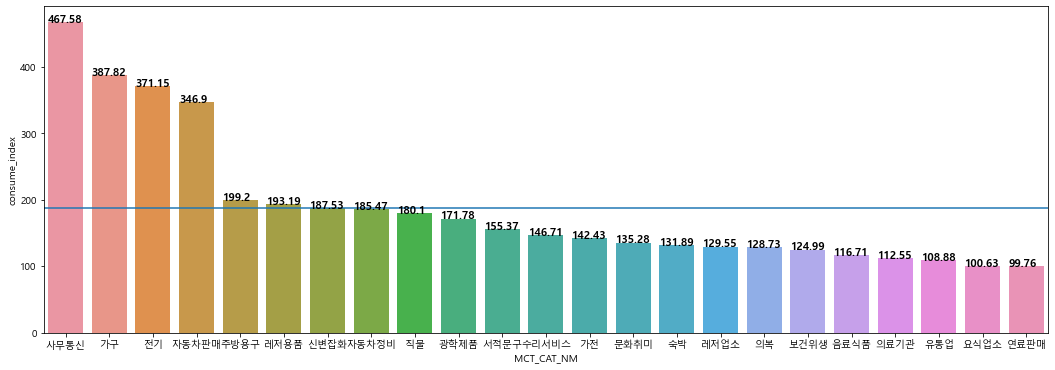

In [790]:
plt.figure(figsize=(18, 6))

# card_sep_seoul_nowon.pivot_table(index=['MCT_CAT_NM'] ,values = 'consume_index', aggfunc='mean').plot(kind='bar')

top_down_index = df['consume_index'].sort_values(ascending=False).index
plot_order = df.iloc[top_down_index]['MCT_CAT_NM'].values
sns.barplot(x = 'MCT_CAT_NM', y='consume_index', data=df, order = plot_order)  
plt.axhline(df['consume_index'].mean())
df = df.sort_values(by="consume_index", ascending=False)
df['consume_index'] = np.round(df['consume_index'],2)
for idx, score in enumerate(df['consume_index']):
    plt.text(idx-0.4, score+0.01, score, size=11, weight='bold')

## 19-21 주차에 전반적인 경향!

## 이제 나눈 지역별로 보기

In [792]:
df_cluster = card_sep.pivot_table(index=['MCT_CAT_NM', 'cluster'] ,values = 'consume_index', aggfunc='mean').reset_index()

## 0번 지역 : 물류 많이시키는 지역(유동인구 줄음)

In [793]:
df_cluster0 = df_cluster[df_cluster['cluster'] == 0]
df_cluster0.reset_index(drop=True, inplace=True)

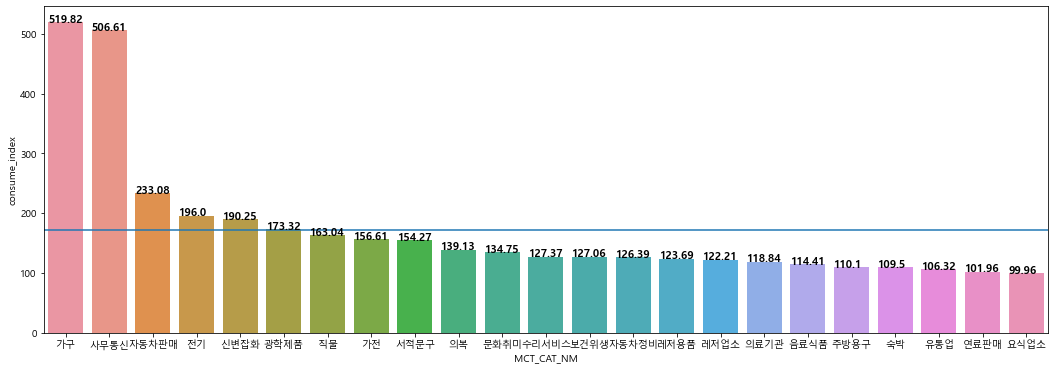

In [794]:
plt.figure(figsize=(18, 6))

# card_sep_seoul_nowon.pivot_table(index=['MCT_CAT_NM'] ,values = 'consume_index', aggfunc='mean').plot(kind='bar')

top_down_index = df_cluster0['consume_index'].sort_values(ascending=False).index
plot_order = df_cluster0.iloc[top_down_index]['MCT_CAT_NM'].values
sns.barplot(x = 'MCT_CAT_NM', y='consume_index', data=df_cluster0, order = plot_order)  
plt.axhline(df_cluster0['consume_index'].mean())
df_cluster0 = df_cluster0.sort_values(by="consume_index", ascending=False)
df_cluster0['consume_index'] = np.round(df_cluster0['consume_index'],2)
for idx, score in enumerate(df_cluster0['consume_index']):
    plt.text(idx-0.4, score+0.01, score, size=11, weight='bold')

## 1번 : 둘다 낮은 지역

In [795]:
df_cluster1 = df_cluster[df_cluster['cluster'] == 1]
df_cluster1.reset_index(drop=True, inplace=True)

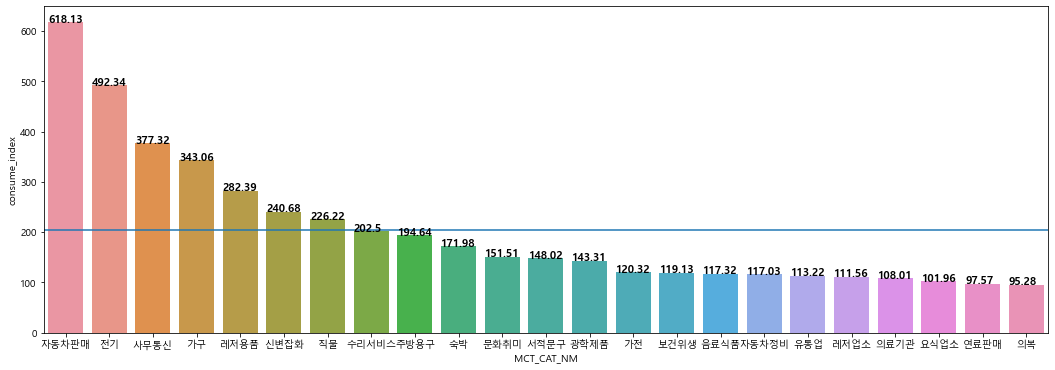

In [796]:
plt.figure(figsize=(18, 6))

# card_sep_seoul_nowon.pivot_table(index=['MCT_CAT_NM'] ,values = 'consume_index', aggfunc='mean').plot(kind='bar')

top_down_index = df_cluster1['consume_index'].sort_values(ascending=False).index
plot_order = df_cluster1.iloc[top_down_index]['MCT_CAT_NM'].values
sns.barplot(x = 'MCT_CAT_NM', y='consume_index', data=df_cluster1, order = plot_order)  
plt.axhline(df_cluster1['consume_index'].mean())
df_cluster1 = df_cluster1.sort_values(by="consume_index", ascending=False)
df_cluster1['consume_index'] = np.round(df_cluster1['consume_index'],2)
for idx, score in enumerate(df_cluster1['consume_index']):
    plt.text(idx-0.4, score+0.01, score, size=11, weight='bold')

## 2번 : 유동인구 둔감한 지역(물류는 조금 덜 시킴)

In [797]:
df_cluster2 = df_cluster[df_cluster['cluster'] == 2]
df_cluster2.reset_index(drop=True, inplace=True)

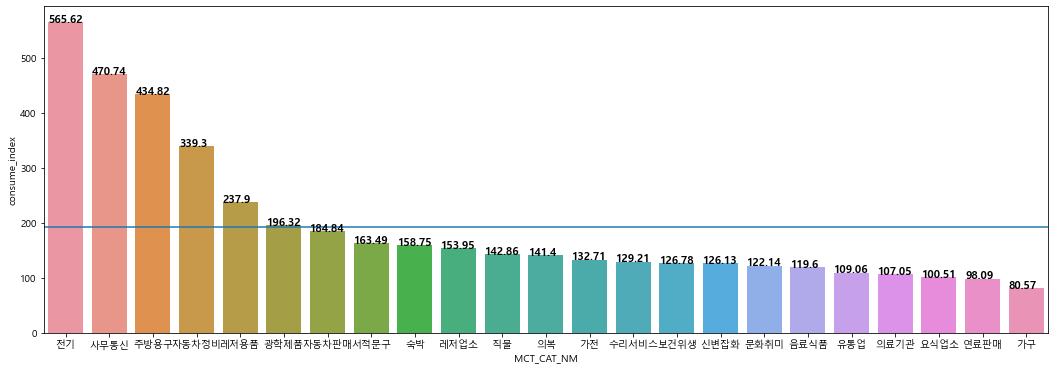

In [798]:
plt.figure(figsize=(18, 6))

# card_sep_seoul_nowon.pivot_table(index=['MCT_CAT_NM'] ,values = 'consume_index', aggfunc='mean').plot(kind='bar')

top_down_index = df_cluster2['consume_index'].sort_values(ascending=False).index
plot_order = df_cluster2.iloc[top_down_index]['MCT_CAT_NM'].values
sns.barplot(x = 'MCT_CAT_NM', y='consume_index', data=df_cluster2, order = plot_order)  
plt.axhline(df_cluster2['consume_index'].mean())
df_cluster2 = df_cluster2.sort_values(by="consume_index", ascending=False)
df_cluster2['consume_index'] = np.round(df_cluster2['consume_index'],2)
for idx, score in enumerate(df_cluster2['consume_index']):
    plt.text(idx-0.4, score+0.01, score, size=11, weight='bold')

## 다같이 보기

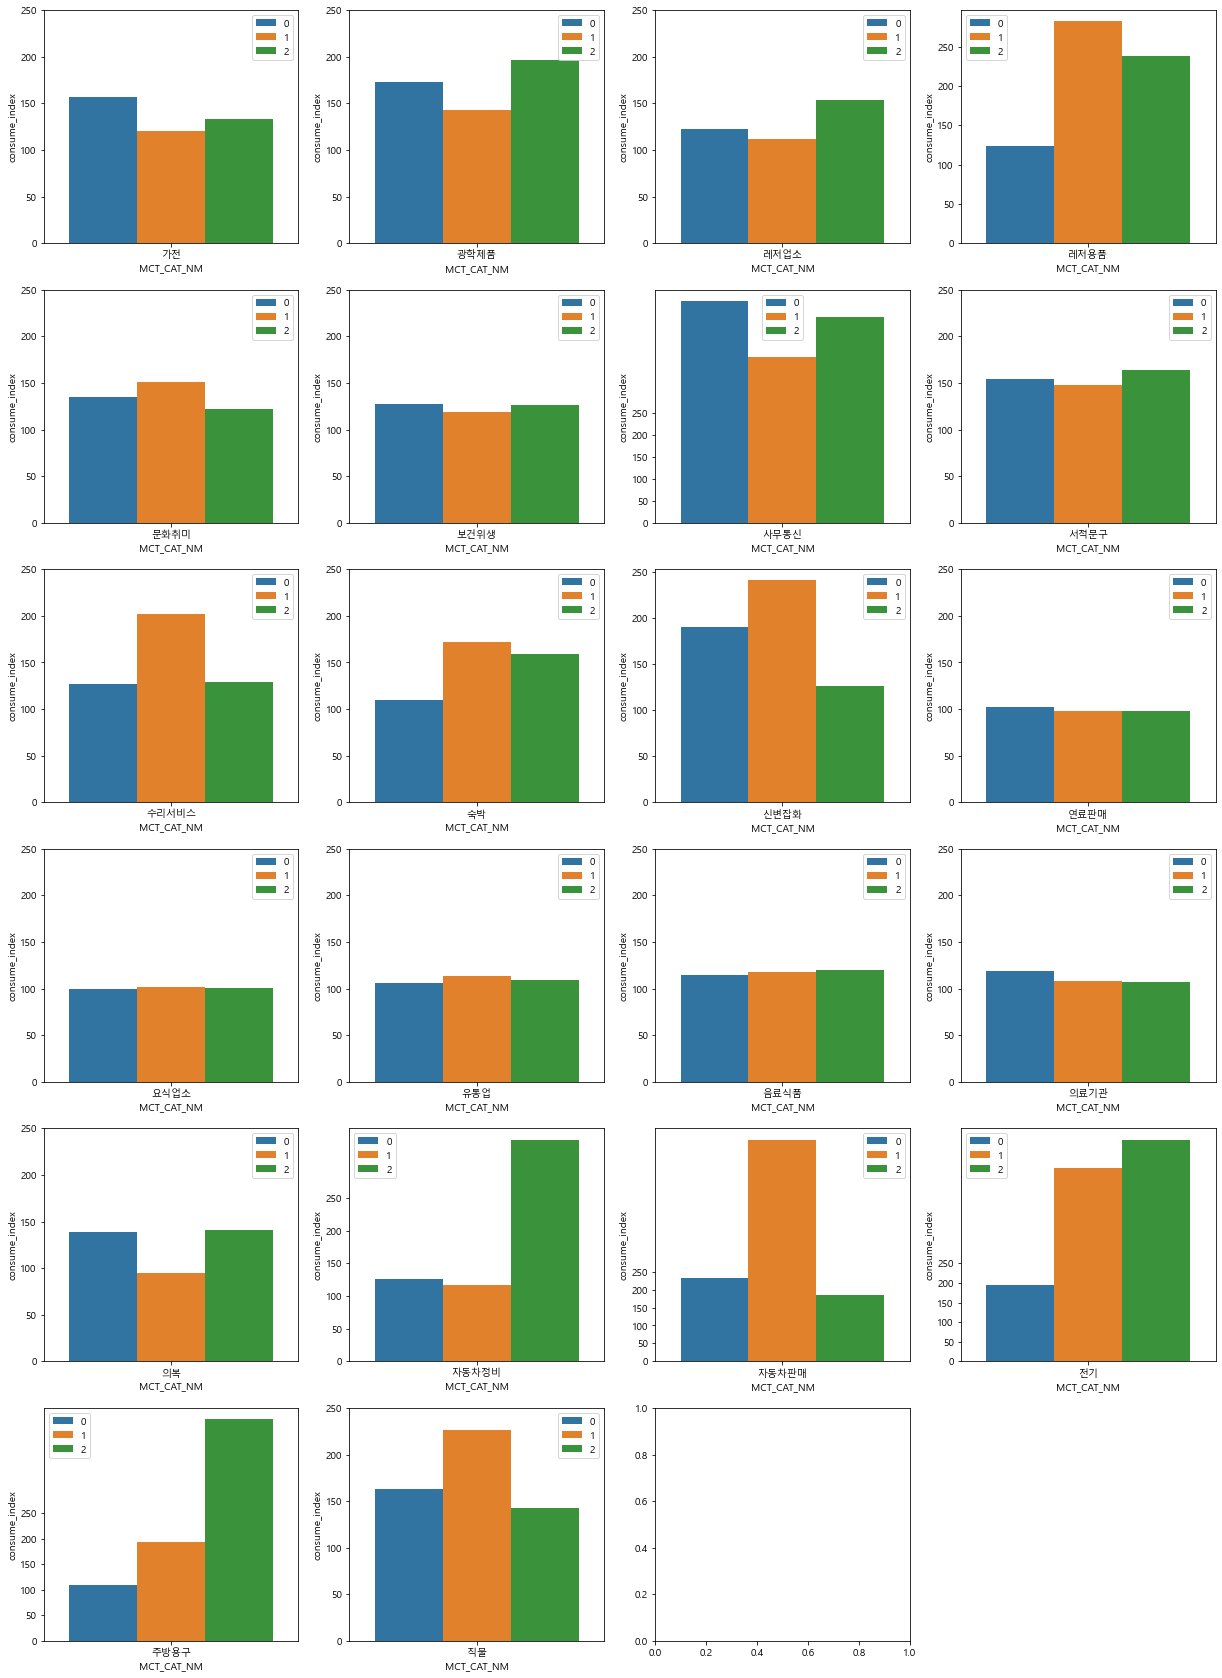

In [799]:
tmp_df = pd.DataFrame()
fig = plt.figure(figsize=(21, 30))
lines = df_cluster['MCT_CAT_NM'].unique()

for idx, line in enumerate(lines):
    tmp_df = df_cluster[df_cluster['MCT_CAT_NM'] == line]    
    sns.barplot(x ='MCT_CAT_NM', y='consume_index', hue='cluster', data = tmp_df)
    plt.legend()
    plt.yticks([0, 50, 100, 150, 200, 250])
    plt.subplot(6,4,idx+1)

([<matplotlib.axis.YTick at 0x19d10b3b400>,
 <a list of 6 Text major ticklabel objects>)

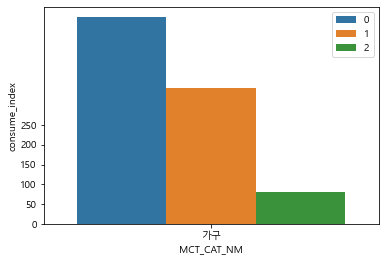

In [800]:
tmp_df = df_cluster[df_cluster['MCT_CAT_NM'] == "가구"]    
sns.barplot(x ='MCT_CAT_NM', y='consume_index', hue='cluster', data = tmp_df)
plt.legend()
plt.yticks([0, 50, 100, 150, 200, 250])

# 물류 송장 건수 가즈아

In [801]:
cj = cj.pivot_table(index=['week_num', 'DL_GD_LCLS_NM', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM', 'year'], values='INVC_CONT', aggfunc='sum').reset_index()

## 내가 보고싶은 19-21

In [802]:
cj_sep = cj[cj['week_num'].isin(range(19,22))]

In [803]:
cj_sep

,week_num,DL_GD_LCLS_NM,CTPV_NM,CTGG_NM,HDNG_NM,year,INVC_CONT
20530,19,가구/인테리어,대구광역시,수성구,고산1동,2019,295
20531,19,가구/인테리어,대구광역시,수성구,고산1동,2020,505
20532,19,가구/인테리어,대구광역시,수성구,고산2동,2019,332
20533,19,가구/인테리어,대구광역시,수성구,고산2동,2020,479
20534,19,가구/인테리어,대구광역시,수성구,고산3동,2019,346
...,...,...,...,...,...,...,...
24664,21,화장품/미용,서울특별시,중구,필동,2020,370
24665,21,화장품/미용,서울특별시,중구,황학동,2019,780
24666,21,화장품/미용,서울특별시,중구,황학동,2020,1115
24667,21,화장품/미용,서울특별시,중구,회현동,2019,982


In [804]:
cj_sep_2019 = cj_sep[cj_sep['year'] == 2019]
cj_sep_2020 = cj_sep[cj_sep['year'] == 2020]
cj_sep = cj_sep_2019.merge(cj_sep_2020, how='inner', on = ['week_num', 'DL_GD_LCLS_NM', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM'])

In [805]:
cj_sep.columns = ['week_num',
 'DL_GD_LCLS_NM',
 'CTPV_NM',
 'CTGG_NM',
 'HDNG_NM',
 'year_2019',
 'INVC_CONT_2019',
 'year_2020',
 'INVC_CONT_2020']

In [806]:
# 소비지수 (2019년을 100으로 보고 지수 산출)
cj_sep['dist_index'] = (cj_sep['INVC_CONT_2020'] * 100) / cj_sep['INVC_CONT_2019']

### cj와 cluster(군집) 테이블에 모두 있는 데이터(동) 들만 사용

In [807]:
cj_sep = cj_sep.merge(cluster_table, how='inner', on = ['CTPV_NM', 'CTGG_NM' , 'HDNG_NM'])

In [808]:
df = cj_sep.pivot_table(index=['DL_GD_LCLS_NM'] ,values = 'dist_index', aggfunc='mean').reset_index()

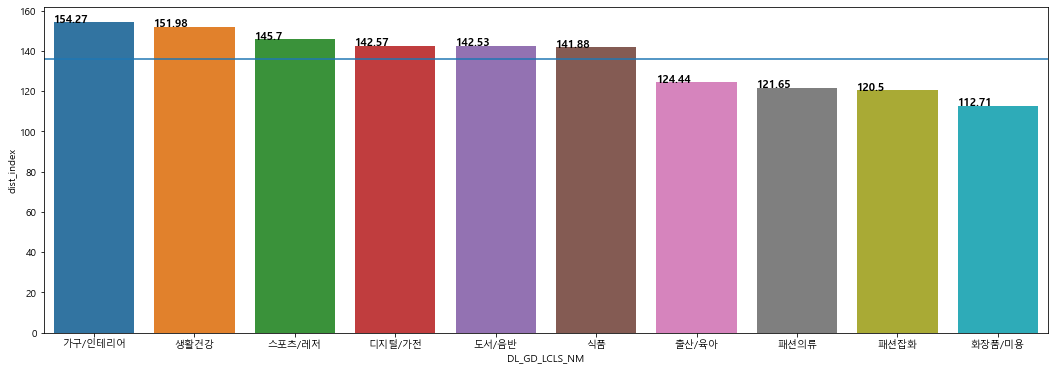

In [809]:
plt.figure(figsize=(18, 6))

# card_sep_seoul_nowon.pivot_table(index=['MCT_CAT_NM'] ,values = 'consume_index', aggfunc='mean').plot(kind='bar')

top_down_index = df['dist_index'].sort_values(ascending=False).index
plot_order = df.iloc[top_down_index]['DL_GD_LCLS_NM'].values
sns.barplot(x = 'DL_GD_LCLS_NM', y='dist_index', data=df, order = plot_order)  
plt.axhline(df['dist_index'].mean())
df = df.sort_values(by="dist_index", ascending=False)
df['dist_index'] = np.round(df['dist_index'],2)
for idx, score in enumerate(df['dist_index']):
    plt.text(idx-0.4, score+0.01, score, size=11, weight='bold')

## 19-21 주차에 전반적인 경향!

## 이제 나눈 지역별로 보기

In [810]:
cj_sep

,week_num,DL_GD_LCLS_NM,CTPV_NM,CTGG_NM,HDNG_NM,year_2019,INVC_CONT_2019,year_2020,INVC_CONT_2020,dist_index,cluster
0,19,가구/인테리어,대구광역시,수성구,고산1동,2019,295,2020,505,171.186441,1
1,19,도서/음반,대구광역시,수성구,고산1동,2019,738,2020,1113,150.813008,1
2,19,디지털/가전,대구광역시,수성구,고산1동,2019,679,2020,1094,161.119293,1
3,19,생활건강,대구광역시,수성구,고산1동,2019,1527,2020,2653,173.739358,1
4,19,스포츠/레저,대구광역시,수성구,고산1동,2019,132,2020,195,147.727273,1
...,...,...,...,...,...,...,...,...,...,...,...
1675,21,식품,서울특별시,중구,회현동,2019,1844,2020,2253,122.180043,0
1676,21,출산/육아,서울특별시,중구,회현동,2019,17,2020,26,152.941176,0
1677,21,패션의류,서울특별시,중구,회현동,2019,1212,2020,1254,103.465347,0
1678,21,패션잡화,서울특별시,중구,회현동,2019,712,2020,774,108.707865,0


In [811]:
df_cluster = cj_sep.pivot_table(index=['DL_GD_LCLS_NM', 'cluster'] ,values = 'dist_index', aggfunc='mean').reset_index()

## 0번 지역 : 물류 많이시키는 지역(유동인구 줄음)

In [812]:
df_cluster0 = df_cluster[df_cluster['cluster'] == 0]
df_cluster0.reset_index(drop=True, inplace=True)

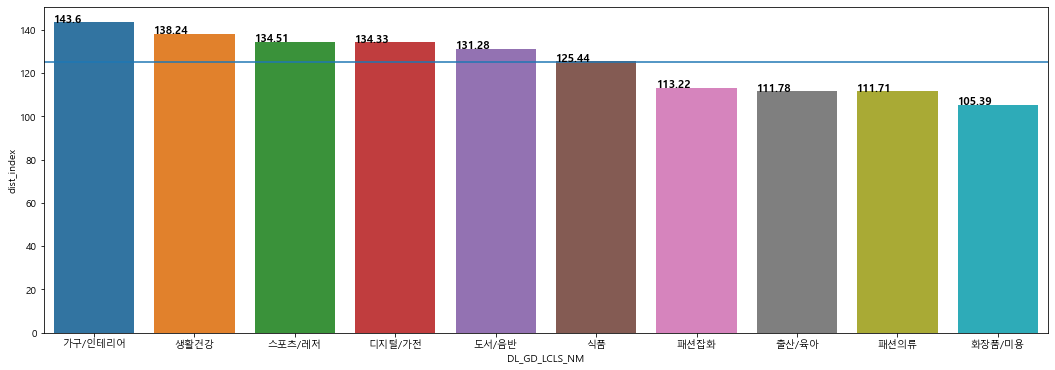

In [813]:
plt.figure(figsize=(18, 6))

# card_sep_seoul_nowon.pivot_table(index=['MCT_CAT_NM'] ,values = 'consume_index', aggfunc='mean').plot(kind='bar')

top_down_index = df_cluster0['dist_index'].sort_values(ascending=False).index
plot_order = df_cluster0.iloc[top_down_index]['DL_GD_LCLS_NM'].values
sns.barplot(x = 'DL_GD_LCLS_NM', y='dist_index', data=df_cluster0, order = plot_order)  
plt.axhline(df_cluster0['dist_index'].mean())
df_cluster0 = df_cluster0.sort_values(by="dist_index", ascending=False)
df_cluster0['dist_index'] = np.round(df_cluster0['dist_index'],2)
for idx, score in enumerate(df_cluster0['dist_index']):
    plt.text(idx-0.4, score+0.01, score, size=11, weight='bold')

## 1번 : 둘다 낮은 지역

In [814]:
df_cluster1 = df_cluster[df_cluster['cluster'] == 1]
df_cluster1.reset_index(drop=True, inplace=True)

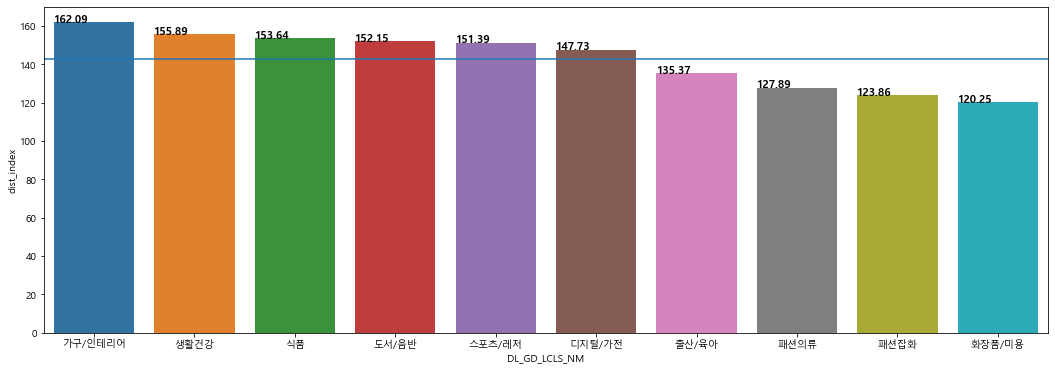

In [815]:
plt.figure(figsize=(18, 6))

# card_sep_seoul_nowon.pivot_table(index=['MCT_CAT_NM'] ,values = 'consume_index', aggfunc='mean').plot(kind='bar')

top_down_index = df_cluster1['dist_index'].sort_values(ascending=False).index
plot_order = df_cluster1.iloc[top_down_index]['DL_GD_LCLS_NM'].values
sns.barplot(x = 'DL_GD_LCLS_NM', y='dist_index', data=df_cluster1, order = plot_order)  
plt.axhline(df_cluster1['dist_index'].mean())
df_cluster1 = df_cluster1.sort_values(by="dist_index", ascending=False)
df_cluster1['dist_index'] = np.round(df_cluster1['dist_index'],2)
for idx, score in enumerate(df_cluster1['dist_index']):
    plt.text(idx-0.4, score+0.01, score, size=11, weight='bold')

## 2번 : 유동인구 둔감한 지역(물류는 조금 덜 시킴)

In [816]:
df_cluster2 = df_cluster[df_cluster['cluster'] == 2]
df_cluster2.reset_index(drop=True, inplace=True)

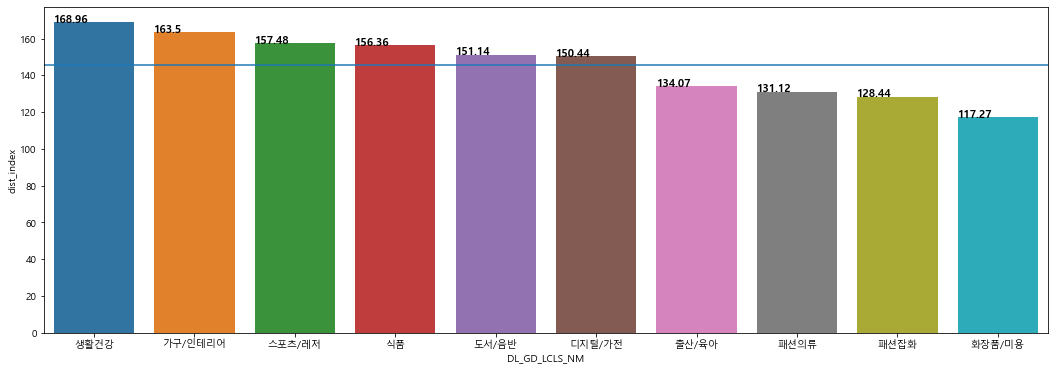

In [817]:
plt.figure(figsize=(18, 6))

# card_sep_seoul_nowon.pivot_table(index=['MCT_CAT_NM'] ,values = 'consume_index', aggfunc='mean').plot(kind='bar')

top_down_index = df_cluster2['dist_index'].sort_values(ascending=False).index
plot_order = df_cluster2.iloc[top_down_index]['DL_GD_LCLS_NM'].values
sns.barplot(x = 'DL_GD_LCLS_NM', y='dist_index', data=df_cluster2, order = plot_order)  
plt.axhline(df_cluster2['dist_index'].mean())
df_cluster2 = df_cluster2.sort_values(by="dist_index", ascending=False)
df_cluster2['dist_index'] = np.round(df_cluster2['dist_index'],2)
for idx, score in enumerate(df_cluster2['dist_index']):
    plt.text(idx-0.4, score+0.01, score, size=11, weight='bold')

## 다같이 보기

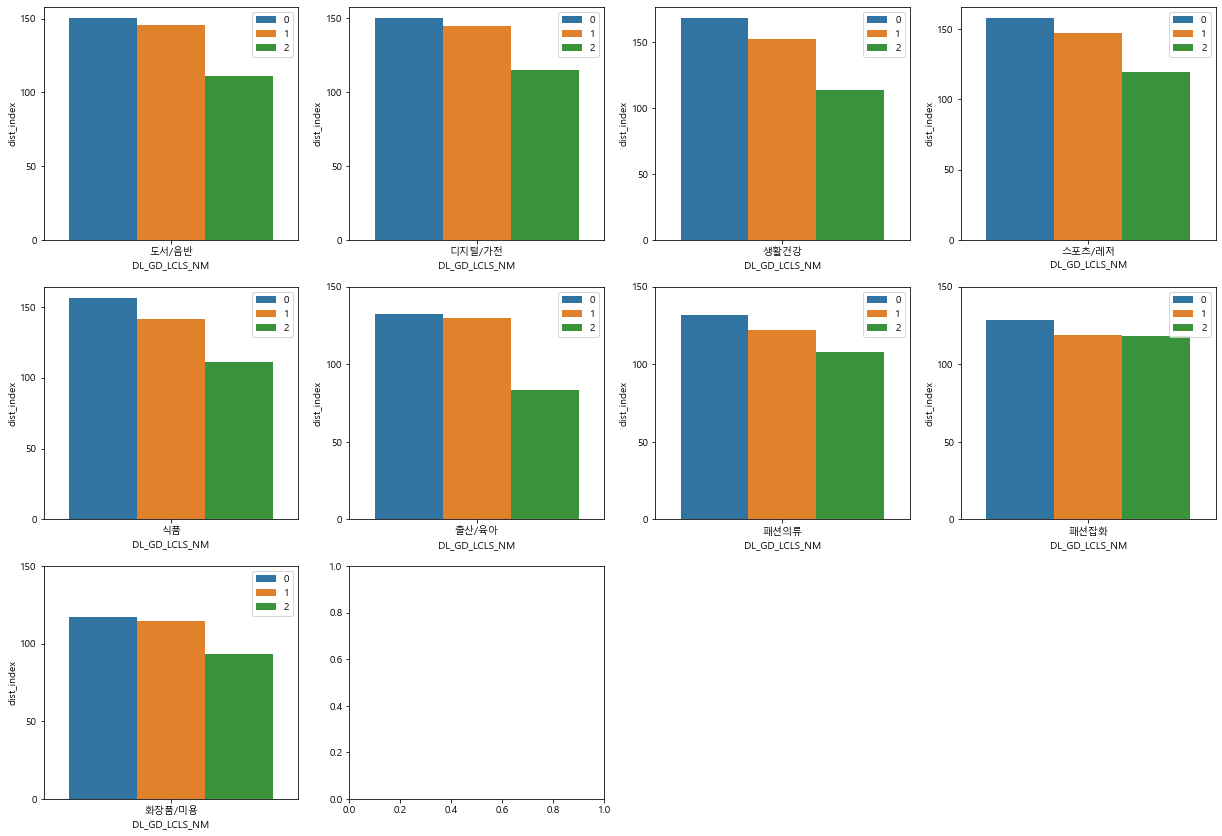

In [377]:
tmp_df = pd.DataFrame()
fig = plt.figure(figsize=(21, 30))
lines = df_cluster['DL_GD_LCLS_NM'].unique()

for idx, line in enumerate(lines):
    tmp_df = df_cluster[df_cluster['DL_GD_LCLS_NM'] == line]    
    sns.barplot(x ='DL_GD_LCLS_NM', y='dist_index', hue='cluster', data = tmp_df)
    plt.legend()
    plt.yticks([0, 50, 100, 150])
    plt.subplot(6,4,idx+1)

([<matplotlib.axis.YTick at 0x19d084410a0>,
 <a list of 4 Text major ticklabel objects>)

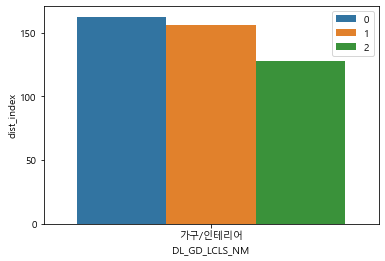

In [378]:
tmp_df = df_cluster[df_cluster['DL_GD_LCLS_NM'] == "가구/인테리어"]    
sns.barplot(x ='DL_GD_LCLS_NM', y='dist_index', hue='cluster', data = tmp_df)
plt.legend()
plt.yticks([0, 50, 100, 150])